In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
import os
import numpy as np
import sys
import os

from skimage.filters import gaussian as gblur
from PIL import Image as PILImage

sys.path.append("..") # Adds higher directory to python modules path.
import brevis
from brevis import branches
from brevis import evaluate
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [2]:
train_ds, test_ds, validation_ds = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar10.load_data(),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 10,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [3]:
# import tensorflow_datasets as tfds
# ds = tfds.load('svhn_cropped', split='train', shuffle_files=True)
# assert isinstance(ds, tf.data.Dataset)
train_ds100, test_ds100, validation_ds100 = brevis.dataset.prepare.dataset(tf.keras.datasets.cifar100.load_data(label_mode="fine"),32,5000,shuffle_size=15000,input_size=(32,32),include_targets=False,num_outputs = 100,reshuffle=True)

augment Dataset
targetsis : False
trainSize 45000
testSize 10000


In [4]:
from scipy.io import loadmat
# Model / data parameters
train_raw = loadmat('./data/svhn/train_32x32.mat')
test_raw = loadmat('./data/svhn/test_32x32.mat')
# Load images and labels
train_images = np.array(train_raw['X'])
test_images = np.array(test_raw['X'])

train_labels = train_raw['y']
test_labels = test_raw['y']
# Fix the axes of the images

train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

print(train_images.shape)
print(test_images.shape)

# Model / data parameters
num_classes = 10
batch_size = 32
input_shape = (32, 32, 1)
# (x_train100, y_train100), (x_test100, y_test100) = tf.keras.datasets.cifar100.load_data(label_mode="fine")
# convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(train_labels, num_classes)
# y_test = keras.utils.to_categorical(test_labels, num_classes)
train_ds_svhn = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_ds_svhn = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
train_ds_svhn = (train_ds_svhn
                .shuffle(buffer_size=15000,seed=42,reshuffle_each_iteration=False)
                .batch(batch_size=batch_size, drop_remainder=False))

test_ds_svhn = (test_ds_svhn
                .batch(batch_size=batch_size, drop_remainder=False))
print(train_ds_svhn)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


In [5]:
class lambda_update(tf.keras.callbacks.Callback):
    def __init__(self, annealing_max,  lambda_t=0, max_t=1):
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)

    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = tf.reduce_min([self.max_t, tf.cast(epoch+self.start_val, tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
        tf.print("annealing coef updated to:", val)
        self.lambda_t.assign(val)

class growth_update(lambda_update):
    ''' callback update method that checks the performance of the model against the validation set to decide if the annealing coef should be increased.
        provides greater control of the additional loss elements by updating their hyperparameters inteligently, rather then with only a preset schedule.
        
    '''
    def __init__(self, annealing_max,  lambda_t=0, max_t=1, starting_epoch = 0):
        self.starting_epoch = starting_epoch
        self.start_val = tf.Variable(initial_value=lambda_t, dtype=tf.float32) 
        
        self.step = tf.Variable(initial_value = 0,dtype=tf.float32)
        self.lambda_t = tf.Variable(initial_value=lambda_t, dtype=tf.float32) #updates each epoch
        self.max_t = tf.Variable(initial_value=max_t, dtype=tf.float32)
        self.annealing_max = tf.Variable(initial_value=annealing_max, dtype=tf.float32)
        self.training = tf.Variable(initial_value=False, dtype=tf.bool)              
        self.past_val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        self.val_acc= tf.Variable(initial_value =0, dtype=tf.float32)
        
    def on_training_begin(self, logs={}):
        ''' indicate that training has begun, so val growth is an option.
        '''
        tf.print("training commenced, validation growth enabled")
        self.training.assign(True)
    def on_epoch_begin(self, epoch, logs={}): #needs to be on begin, otherwise the epoch update won't increase the value from 0 to 0.1 till the 3rd epoch...
        val = self.lambda_t
        if epoch >= self.starting_epoch:
            if self.val_acc >= self.past_val_acc:
                val = tf.reduce_min([self.max_t, tf.cast((self.step - self.starting_epoch) +self.start_val , tf.dtypes.float32) / tf.cast(self.annealing_max, tf.dtypes.float32)])
                tf.print("annealing coef updated to:", val)
                self.lambda_t.assign(val)
                self.past_val_acc.assign(self.val_acc)
                self.step.assign(self.step + 1)
            else:
                tf.print("val acc did not improve from {}, annealing coef not updated, remains at:{}".format(self.past_val_acc.numpy(), val.numpy()))
    def on_test_end(self, logs=None):
        """ if training, save the performance results
        """
        self.val_acc.assign(logs.get('branch_exit_accuracy')+logs.get('branch_exit_1_accuracy'))
        

In [6]:

def exp_evidence(logits): 
    return tf.exp(tf.clip_by_value(logits/10,-10,10))

def KL(alpha,K):
    # print("K:",K)
    beta=tf.constant(np.ones((1,K)),dtype=tf.float32)
    S_alpha = tf.reduce_sum(alpha,axis=1,keepdims=True)
    S_beta = tf.reduce_sum(beta,axis=1,keepdims=True)
    lnB = tf.compat.v1.lgamma(S_alpha) - tf.reduce_sum(tf.compat.v1.lgamma(alpha),axis=1,keepdims=True)
    lnB_uni = tf.reduce_sum(tf.compat.v1.lgamma(beta),axis=1,keepdims=True) - tf.compat.v1.lgamma(S_beta)
    dg0 = tf.compat.v1.digamma(S_alpha)
    dg1 = tf.compat.v1.digamma(alpha)
    kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
    return kl


def _KL(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    '''
    New KL divergence function. 
    '''
    target_alphas = tf.cast(target_alphas,tf.float32)
    alphas = tf.cast(alphas,tf.float32)
    if not precision:
        precision = tf.reduce_sum(alphas, axis=1, keepdims=True)
    if not target_precision:
        target_precision = tf.reduce_sum(target_alphas, axis=1, keepdims=True)
    precision = tf.cast(precision,tf.float32)
    target_precision = tf.cast(target_precision,tf.float32)
    
    precision_term = tf.compat.v1.lgamma(target_precision) - tf.compat.v1.lgamma(precision)
    alphas_term = tf.reduce_sum(
        tf.compat.v1.lgamma(alphas + epsilon)
        - tf.compat.v1.lgamma(target_alphas + epsilon)
        + (target_alphas - alphas)
        * (
            tf.compat.v1.digamma(target_alphas + epsilon)
            - tf.compat.v1.digamma(target_precision + epsilon)
        ),
        axis=1,
        keepdims=True,
    )
    cost = tf.squeeze(precision_term + alphas_term)
    return cost

def reverse_kl(alphas, target_alphas,  precision=None, target_precision=None, epsilon=1e-8):
    return _KL(target_alphas,alphas, precision=None, target_precision=None, epsilon=1e-8)



def DirichletKLLoss(labels, logits, reverse=True):
    # alpha = tf.exp(logits)
    # alpha = tf.exp(tf.clip_by_value(logits/10,-10,10))
    alpha = tf.nn.softplus(logits)
    target_concentration = tf.reduce_sum(alpha,axis=1,keepdims=True)
    target_alphas = (tf.ones_like(alpha) + (target_concentration * labels))
    alpha = alpha + 1
    if reverse:
        cost = reverse_kl(alpha, target_alphas)
    else:
        cost = _KL(alpha, target_alphas)
    if tf.math.is_nan(tf.reduce_sum(cost)):
        tf.print("logits",logits, summarize=-1)
        tf.print("alpha",alpha, summarize=-1)
        tf.print("cost", cost, summarize=-1)
    return cost




In [7]:
from scipy.special import logsumexp



def MAEBM(lambda_callback: lambda_update):
    import tensorflow_probability as tfp
    def MAEBM_loss(labels, outputs):
        n_classes=10
        evidence = tf.nn.softplus(outputs)
        alpha = evidence + 1
        soft_output= labels
        S = tf.reduce_sum(alpha,axis=1,keepdims=True)
        alpha_0 = S * tf.ones((outputs.shape[-1]))
        UCE_loss = tf.reduce_mean(
            tf.cast(soft_output,dtype=tf.float32) * (tf.compat.v1.digamma(alpha_0) - tf.compat.v1.digamma(alpha))
        )
        annealing_coef =  lambda_callback.lambda_t
        dirichlet_weight = 0.1 * tf.reduce_mean(-tfp.distributions.Dirichlet(alpha).entropy())
        UCE_loss = (
            UCE_loss + dirichlet_weight
        )
        return UCE_loss
    return MAEBM_loss



def cross_energy(lambda_callback: lambda_update):
    #create a wrapper function that returns a function
    def cross_entropy_evidence(labels, outputs): 
        softmax = tf.nn.softmax(outputs)
        
        evidence = exp_evidence(outputs)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=1, keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum(labels * (tf.compat.v1.digamma(S) - tf.compat.v1.digamma(alpha)), axis=1, keepdims=True)
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        alp = E*(1-labels) + 1 
        loss = tf.keras.losses.categorical_crossentropy(labels,softmax)
        annealing_rate =  lambda_callback.lambda_t
        # beta=tf.constant(np.ones((1,10)),dtype=tf.float32)
        # C =  annealing_rate * KL(alp,10)
        #A = annealing_rate * A
        
        Ec_in = -tf.math.reduce_logsumexp(outputs)
        # Ec_in = -torch.logsumexp(x[:len(in_set[0])], dim=1)
        # tf.print(0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)))
        # energy_loss = 0.1*(pow(tf.nn.relu(Ec_in- (-23)), 2)) #+ torch.pow(F.relu(args.m_out-Ec_out), 2).mean()) OLD METHOD< DID WORSE THEN ENERGY on EDL
        
        #so what about EDL + energy? 
        # val = y_hat * tf.math.log(y_hat)/tf.math.log(tf.constant(2, dtype=y_hat.dtype))
        # sumEntropies =  tf.reduce_sum(tf.boolean_mask(val,tf.math.is_finite(val)))
        energy_loss = annealing_rate * (tf.math.log(evidence)/tf.math.log(tf.constant(2, dtype=evidence.dtype)))
        
        # return loss + energy_loss #+  C
        return (A + B) + energy_loss 
    return  cross_entropy_evidence

import tensorflow_probability as tfp

def brevisEnergy(lambda_callback: lambda_update):
    ''' Proposed Loss function for BrevisNet branch classifiers
        consists of the expected mean square error loss + reverse dirichlet KL + regularizing dirichlet entropy mean
    '''
    def brevisEnergy(p, logits):
        evidence = tf.exp(logits)
        # evidence = tf.exp(tf.clip_by_value(logits/10,-10,10))
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        alp = E*(1-p) + 1 
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy()) ###entropy of the dirichlet distribution as a smoothing regularizer. 
        return (A+B) + C + D
    return  brevisEnergy


def Brevis_loss_final(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        # evidence = exp_evidence(logits)
        evidence = tf.nn.softplus(logits)
        alpha = evidence + 1

        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        # tf.print(annealing_coef)
        # annealing_coef = 
        
    
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)

        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        
        
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        # print(B_1)
        # print(B_2)
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * info_reg
        
        # annealing_coef =  0.0001
        alp = E*(1-p) + 1 
        C =   annealing_coef * KL(alp,10)
        
        
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        return (A + B) + C + D #+ info_reg + C + D
    return custom_loss_function

In [125]:
model = tf.keras.models.load_model("./models/journal_models/resnet_CE_entropy_finetuned.hdf5")

In [126]:
model.fit(train_ds,validation_data=validation_ds, epochs =1 )

1407/1407 [==============================] - 83s 57ms/step - loss: 0.2953 - accuracy: 0.9053 - val_loss: 0.9480 - val_accuracy: 0.7454


In [23]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 15ms/step - loss: 0.8078 - accuracy: 0.7815


[0.8078320622444153, 0.781499981880188]

In [9]:
# model.save('./models/cifaroutlier_EDL_RKL.hdf5')
# model = tf.keras.models.load_model('./models/cifaroutlier_EDL_adam.hdf5',custom_objects={"custom_loss_function":loss_wrapper(lambda_callback),"entropy":entropyMetric()})

In [8]:

def _branch_conv1(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv1_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(2,2), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    # branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

def _branch_conv2_SM(prevLayer, targets=None, teacher_sm = None, teaching_features=None):
    """ Add a new branch to a model connecting at the output of prevLayer. 
        NOTE: use the substring "branch" in all names for branch nodes. this is used as an identifier of the branching layers as opposed to the main branch layers for training
    """ 
#     branchLayer = keras.layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(prevLayer)
#     branchLayer = keras.layers.Dense(124, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch124"))(branchLayer)
#     branchLayer = keras.layers.Dense(64, activation="relu",name=tf.compat.v1.get_default_graph().unique_name("branch64"))(branchLayer)
#     output = keras.layers.Dense(10, name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(prevLayer.shape))(prevLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.Conv2D(filters=128, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)  
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = keras.layers.Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_conv2d"), input_shape=(branchLayer.shape))(branchLayer)
    branchLayer = keras.layers.BatchNormalization(name=tf.compat.v1.get_default_graph().unique_name("branch_batchnorm"))(branchLayer)
    branchLayer = keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2),name=tf.compat.v1.get_default_graph().unique_name("branch_maxpool"))(branchLayer)
    # branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Flatten(name=tf.compat.v1.get_default_graph().unique_name("branch_flatten"))(branchLayer)
    branchLayer = layers.Dense(1024,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    branchLayer = keras.layers.Dropout(0.2,name=tf.compat.v1.get_default_graph().unique_name("branch_dropout"))(branchLayer)
    branchLayer = layers.Dense(512,activation='relu',name=tf.compat.v1.get_default_graph().unique_name("branch_dense"))(branchLayer)
    output = keras.layers.Dense(10, activation='softmax', name=tf.compat.v1.get_default_graph().unique_name("branch_exit"))(branchLayer)
    # output = (layers.Softmax(name=tf.compat.v1.get_default_graph().unique_name("branch_softmax"))(output))
    return output

In [9]:
from tensorflow.python.platform import tf_logging as logging
class _earlyStopping(keras.callbacks.EarlyStopping):
    def __init__(self,
               monitor='val_loss',
               min_delta=0,
               patience=0,
               verbose=0,
               mode='auto',
               baseline=None,
               restore_best_weights=False):
        self.monitor = monitor
        self.patience = patience
        self.verbose = verbose
        self.baseline = baseline
        self.min_delta = abs(min_delta)
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        # super(_earlyStopping, self).__init__(monitor=)
        if mode not in ['auto', 'min', 'max']:
            logging.warning('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.', mode)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            
            # if (self.monitor.endswith('acc') or self.monitor.endswith('accuracy') or self.monitor.endswith('auc')):
            self.monitor_op = np.greater
            # else:
                # self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

        self.monitor_op = np.greater
        self.min_delta *= 1
        
    def get_monitor_value(self, logs):
        logs = logs or {}
        monitor_value = 0
        if type(self.monitor) is list:
            for i in self.monitor:
                _log_val = logs.get(i)
                # logging.warning("values are {}, {}".format(i,_log_val))
                if _log_val is None:
                    logging.warning('Metric `%s` '
                          'for early stopping is not available. Available metrics are: %s',
                          i, ','.join(list(logs.keys())))
                else:
                    monitor_value += _log_val
        # monitor_value = logs.get(self.monitor)
        if monitor_value is None:
            logging.warning('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s',
                          self.monitor, ','.join(list(logs.keys())))
        return monitor_value


In [83]:
tf.keras.backend.clear_session()

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(C)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     


growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
earlyStop = _earlyStopping(monitor=["val_classification_accuracy","val_branch_exit_accuracy","val_branch_exit_1_accuracy"],patience=5,restore_best_weights=True)

model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          target_input=False,loop=False,num_outputs=10)
model.setTrainable(True)
model.compile(loss=[trunk_loss,CE_loss,CE_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001AD6D320208>
Freezing Main Layers and setting branch layers training to true


In [74]:

# lr_schedule
model.fit(train_ds, validation_data=validation_ds, transfer = False,epochs = 60,callbacks=[growth_callback,earlyStop])

Setting Main Layers  and branch layers training to true
annealing coef updated to: 0
Epoch 1/60
1407/1407 [==============================] - 49s 31ms/step - loss: 2.2800 - classification_loss: 0.1499 - branch_exit_loss: 1.0533 - branch_exit_1_loss: 1.0768 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6333 - branch_exit_1_accuracy: 0.6258 - val_loss: 2.4600 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.8563 - val_branch_exit_1_loss: 0.8355 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.7046 - val_branch_exit_1_accuracy: 0.7186
annealing coef updated to: 0.01
Epoch 2/60
1407/1407 [==============================] - 41s 29ms/step - loss: 1.7123 - classification_loss: 0.1499 - branch_exit_loss: 0.7648 - branch_exit_1_loss: 0.7976 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.7346 - branch_exit_1_accuracy: 0.7276 - val_loss: 2.3863 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.8103 - val_branch_exit_1_loss: 0.8078 -

In [75]:
model.evaluate(test_ds)

313/313 [==============================] - 6s 19ms/step - loss: 2.7936 - classification_loss: 0.8078 - branch_exit_loss: 1.2463 - branch_exit_1_loss: 0.7394 - classification_accuracy: 0.7815 - branch_exit_accuracy: 0.7420 - branch_exit_1_accuracy: 0.7755


[2.7935733795166016,
 0.8078323006629944,
 1.2463067770004272,
 0.739434540271759,
 0.781499981880188,
 0.7419999837875366,
 0.7754999995231628]

In [11]:
tf.keras.backend.clear_session()

def loss_wrapper(lambda_callback: lambda_update):
    ''' Loss function of Evidential Dirichlet Networks
        Expected Mean Square Error + KL divergence
    '''
    def custom_loss_function(p, logits):
    #     alpha = alpha + 1
        evidence = exp_evidence(logits)
        # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t
        
        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        
        # annealing_coef =  0.0001
        # alp = E*(1-p) + 1 
        # C =   annealing_coef * KL(alp,10)
        # C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # tf.print((A + B),summarize=-1)
        # tf.print((info_reg + D),summarize=-1)
        
        # tf.print(((A + B) + info_reg + D).shape)
        return (A + B) + info_reg +  D # info_reg + D  #+ info_reg #+ C + D
    return custom_loss_function

def auxLoss(lambda_callback: lambda_update):
    def auxloss(p, logits):
        evidence = exp_evidence(logits)
            # evidence = tf.nn.softplus(logits)
        alpha = evidence + 1
        S = tf.reduce_sum(alpha,axis=1,keepdims=True) 
        E = alpha - 1
        m = alpha / S
        A = tf.reduce_sum((p-m)**2, axis=1, keepdims=True) 
        B = tf.reduce_sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True) 
        annealing_coef =  lambda_callback.lambda_t

        bool_mask = tf.cast(p,tf.bool)
        ic_mask = tf.cast(1 - p,tf.bool)
        ic_bool_mask = tf.cast(ic_mask,tf.bool)
        ic_alpha_masked = tf.cast(tf.ragged.boolean_mask(alpha, ic_bool_mask).to_tensor(),tf.float32)
        #### info reg
        _A = (ic_alpha_masked -1) ** 2
        B_1 = tf.math.polygamma(1.,ic_alpha_masked) 
        B_2 = tf.math.polygamma(1., tf.reduce_sum(ic_alpha_masked,axis=1,keepdims=True))
        _B = (B_1 - B_2)
        info_reg =  .5* tf.reduce_sum(_A * _B,axis=1)
        info_reg = annealing_coef * (info_reg * 2)
        C =   annealing_coef * DirichletKLLoss(p,logits, True)
        D = 0.0001 * -tf.reduce_mean(tfp.distributions.Dirichlet(alpha).entropy())
        # return (A + B) + C #+ D #+ info_reg #+ C + D
        # tf.print(C)
        return tf.reduce_mean(info_reg+ D )
    return auxloss     


growth_callback = growth_update(100,0.,max_t = 1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
CE_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)

# def scheduler(epoch,lr):
#     if epoch < 5:
#         tf.print("learning rate set to",lr)
#         return lr
#     else:
#         modif = 1+ (epoch % 5) /10
#         tf.print("learning rate set to",lr * modif)
#         return lr  * modif
# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
    

model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv1,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          target_input=False,loop=False,num_outputs=10)
model.setTrainable(True)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,CE_loss,CE_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.1),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
                  # optimizer="adam",
               metrics=['accuracy'])




Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x0000018DE2FD53C8>
Freezing Main Layers and setting branch layers training to true


In [58]:
model.save("./models/journal_models/resnet_EDL_ES26.hdf5")

In [86]:
model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
outputs = [[model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.164 G


In [84]:

outputs = [ [model.get_layer("branch_exit").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0)],
            [model.get_layer("branch_exit").get_output_at(0),model.get_layer("branch_exit_1").get_output_at(0),model.get_layer("classification").get_output_at(0)]
          ]
from keras_flops import get_flops    
for _outputs in outputs:
    temp_model = tf.keras.models.Model(inputs=model.inputs, outputs=_outputs)
    # Calculae FLOPS
    print(temp_model.outputs)
    flops = get_flops(temp_model, batch_size=1)
    print(f"FLOPS: {flops / 10 ** 9:.03} G")
    

[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>]
FLOPS: 0.0271 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
FLOPS: 0.0548 G
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>]
FLOPS: 0.186 G


In [79]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)
model = tf.keras.models.load_model("./models/journal_models/resnet_EDL_ES26.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"auxloss":auxlossMetric,"growth_callback":growth_callback,"custom_loss_function":branch_loss})



In [18]:
import random
seed = 42
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
tf.keras.backend.clear_session()

growth_callback = growth_update(50,0.,max_t = 0.1, starting_epoch =0)

auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)


branch_loss = keras.losses.CategoricalCrossentropy(from_logits=True)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)



model = brevis.BranchModel(name="./models/journal_models/resnet_CE_entropy_finetuned.hdf5", custom_objects={})
# model.add_branches([_branch_flat,_branch_flat],
#                           ["conv2_block1_out","conv2_block3_out",
#                             # "dense"
#                           ],
#                           target_input=False,loop=False,num_outputs=10)

model.add_branches([_branch_conv2,_branch_conv2],
                          ["conv2_block1_out","conv2_block3_out",
                          ],
                          target_input=False,loop=False,num_outputs=10)
model.setTrainable(True)
# model.compile(loss = [trunk_loss,loss_fn,loss_fn], optimizer=tf.optimizers.SGD(learning_rate=0.001, momentum=0.9),metrics=['accuracy'])
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  # optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,  beta_1=0.99,  beta_2=0.999,),
              preset="", metrics=['accuracy',auxlossMetric])


Matching Branchpoint by id number
Matching Branchpoint by name
add Branch to branch point  conv2_block1_out
add Branch to branch point  conv2_block3_out
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_9'), name='input_9', description="created by layer 'input_9'")
[<KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'classification')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'branch_exit_1')>]
branch added <brevis.core_v2.BranchModel object at 0x000001C0A9597D08>
Freezing Main Layers and setting branch layers training to true

preset: Other


In [19]:
model.fit(train_ds, epochs = 10, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0
Epoch 1/10
1407/1407 [==============================] - 41s 26ms/step - loss: 2.4958 - classification_loss: 0.1499 - branch_exit_loss: 1.2672 - branch_exit_1_loss: 1.0787 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.5468 - branch_exit_1_accuracy: 0.6274 - val_loss: 2.7275 - val_classification_loss: 0.7682 - val_branch_exit_loss: 1.0590 - val_branch_exit_1_loss: 0.9002 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.6264 - val_branch_exit_1_accuracy: 0.6920
annealing coef updated to: 0.02
Epoch 2/10
1407/1407 [==============================] - 35s 25ms/step - loss: 1.9192 - classification_loss: 0.1499 - branch_exit_loss: 0.9770 - branch_exit_1_loss: 0.7923 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.6581 - branch_exit_1_accuracy: 0.7287 - val_loss: 2.3964 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.8799 - val_branch_exit_1_loss: 

In [71]:
model.save("./models/journal_models/resnet_CE_ES12.hdf5")

In [46]:
# import random
# seed = 42
# random.seed(seed)
# tf.random.set_seed(seed)
# np.random.seed(seed)
# tf.keras.backend.clear_session()

growth_callback = growth_update(100,0.,max_t = 1., starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
# branch_loss = loss_wrapper(growth_callback)


branch_loss = loss_wrapper(growth_callback)
trunk_loss = keras.losses.CategoricalCrossentropy(from_logits=False)
# loss = kl_loss(lambda_callback)
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True)


model = tf.keras.models.load_model("./models/journal_models/resnet_CE_ES12.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"growth_callback":growth_callback,"custom_loss_function":branch_loss})
# resnet_brevis_10_2

In [42]:
model.setTrainable(True)
model.compile(loss=[trunk_loss,branch_loss,branch_loss], 
                  optimizer=tf.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                  # optimizer="adam",
              preset="", metrics=['accuracy',auxlossMetric])
model.fit(train_ds, epochs = 8, validation_data=validation_ds, transfer=True,callbacks=[growth_callback])

Freezing Main Layers and setting branch layers training to true

preset: Other
Freezing Main Layers and setting branch layers training to true
annealing coef updated to: 0.4
Epoch 1/8
1407/1407 [==============================] - 57s 37ms/step - loss: 1.1642 - classification_loss: 0.1499 - branch_exit_loss: 0.5609 - branch_exit_1_loss: 0.4533 - classification_accuracy: 0.9525 - branch_exit_accuracy: 0.7613 - branch_exit_1_accuracy: 0.8192 - val_loss: 2.0384 - val_classification_loss: 0.7682 - val_branch_exit_loss: 0.6598 - val_branch_exit_1_loss: 0.6104 - val_classification_accuracy: 0.7874 - val_branch_exit_accuracy: 0.7188 - val_branch_exit_1_accuracy: 0.7566
val acc did not improve from 1.4775999784469604, annealing coef not updated, remains at:0.4000000059604645
Epoch 2/8
1407/1407 [==============================] - 50s 36ms/step - loss: 1.1474 - classification_loss: 0.1499 - branch_exit_loss: 0.5538 - branch_exit_1_loss: 0.4437 - classification_accuracy: 0.9525 - branch_exit_accura

KeyboardInterrupt: 

In [121]:
# lambda_callback = lambda_update(1000,0,max_t = 0.01)
growth_callback = growth_update(100,0,max_t = 0.1, starting_epoch =0)

# auxlossMetric = auxLoss(growth_callback)
branch_loss = loss_wrapper(growth_callback)

# model = tf.keras.models.load_model("./models/journal_models/resnet_EDL_e15_g100.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"auxloss":auxlossMetric,"growth_callback":growth_callback,"custom_loss_function":branch_loss})
model = tf.keras.models.load_model("./models/journal_models/resnet_CE_ES12.hdf5",custom_objects={"BranchModel":brevis.BranchModel,"auxloss":auxlossMetric,"growth_callback":growth_callback,"custom_loss_function":branch_loss})



In [80]:
#if EDL
output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['energy'], stopping_point=None)

#if CE
# output_ID= evaluate.getPredictions_Energy(model, test_ds,  values =['entropy'], stopping_point=None)
for i in output_ID:
    i['outlier']=0


outputs 3
['energy']
True


In [81]:
#if EDL
output_OOD= evaluate.getPredictions_Energy(model, test_ds100,  values =['energy'], stopping_point=None)

#if CE
# output_OOD= evaluate.getPredictions_Energy(model, test_ds100,  values =['entropy'], stopping_point=None)

for i in output_OOD:
    i['correct']=0
    i['outlier']=1

outputs 3
['energy']
True


In [23]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
        
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds, plots


{'fpr': array([0.        , 0.        , 0.        , ..., 0.81202241, 0.82093734,
       1.        ]), 'tpr': array([0.00000000e+00, 4.65549348e-04, 1.86219739e-03, ...,
       9.98603352e-01, 9.99068901e-01, 1.00000000e+00]), 'label': 'entropy', 'ix': 1828}
{'fpr': array([0.00000000e+00, 1.35574837e-04, 1.35574837e-04, ...,
       9.13096529e-01, 9.13096529e-01, 1.00000000e+00]), 'tpr': array([0.00000000e+00, 0.00000000e+00, 3.81097561e-04, ...,
       9.99618902e-01, 1.00000000e+00, 1.00000000e+00]), 'label': 'entropy', 'ix': 1934}


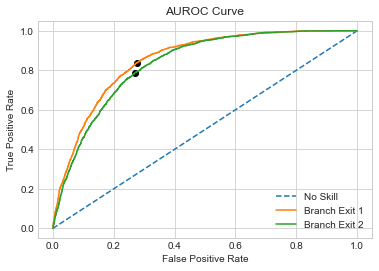

In [49]:
metric = "entropy"
plots=[]
for _ID in output_ID:
    AUC_thresholds, plot = calc_AUC(_ID, metrics=metric, plot = False)
    plots.append(plot)
    # thresh,plots =AUC_thresholds
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
labels = ["Branch Exit 1","Branch Exit 2","Trunk Exit"]
for i, x in enumerate(plots):
    if i == len(plots)-1:
        continue
    for plot in x:
        print(plot)

        ix = plot['ix']
        plt.plot(plot["fpr"], plot["tpr"], linestyle='-', label=labels[i])

        plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("AUROC Curve")
plt.legend()
# show the plot
plt.show()


In [99]:
def EvaluateOOD(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    '''
    Build an evaluation plot of the branched model's performance on ID and OOD datasets.

    ::Variables::
    ID: in-distribution dataset
    OOD: out of distribution dataset
    metrics: list of strings of metrics to evaluate branch results with. can be any of the following: ["gmean", "mean", "PR_AUC"]
    exit: #if a specific exit number is specified, only output the results of that exit. counts from 0 - N, with 0 being the main exit. -1 returns all exits
    legend: specify a legend to use for the plot
    main_exit_included: specify if the last exit must answer all inputs recieved, if False, it will use the threshold to accept and reject inputs
    plot: choose to produce a plot or just the table of branch results
    exit_labels: what labels to use for the exits, defaults to "exit_N" 
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _OOD = OOD.copy()
        _ID.append(_ID.pop(0))
        _OOD.append(_OOD.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Input_OOD=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            _OOD = [_OOD[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
        for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            legend = ["Branch Threshold","Correct ID Predictions","Incorrect ID Predictions", "OOD Inputs"]
            Correct = output_ID.loc[(output_ID['correct'] == True)]
            Incorrect = output_ID.loc[(output_ID['correct'] == False)]
            if plot:
                
                _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

            if plot:
                plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                plt.title(metric.capitalize() + " Outliers", weight="bold")
                # plt.legend(legend)
                plt.xlabel(metric.capitalize() + " Score", weight="bold")
                plt.ylabel("Frequency", weight="bold")
                plt.legend(legend,frameon=True)
                
                ## arrow annotation
                if lessThanMetrics:
                    ymax = plt.gca().get_ylim()
                    xmax = plt.gca().get_xlim()
                    ywidth = abs(ymax[0] - ymax[1])
                    xwidth = abs(xmax[0] - xmax[1])
                    print(ymax, ywidth)
                    print(xmax, _threshold- xmax[1]/10 )
                    
                    plt.text(max(_threshold- xwidth/4,xmax[0]) , (ywidth/1.5) + ywidth/60 ,"Accepted Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold - xwidth/4, ywidth/1.5), xytext=(_threshold, ywidth/1.5), arrowprops=dict(arrowstyle="->"))
                    
                    plt.text(min(_threshold + xwidth/80,xmax[1]), (ywidth/2)+ ywidth/60,"Rejected Inputs",wrap=True)
                    plt.annotate("", xy=(_threshold + xwidth/4, ywidth/2), xytext=(_threshold, ywidth/2),  arrowprops=dict(arrowstyle="->"))
                else:
                    plt.annotate("", xy=(_threshold, 100), xytext=(_threshold, 0), arrowprops=dict(arrowstyle="->"))
                    
                plt.show()
            if main_exit_included and i == len(_ID)-1 :
                Exit_Name.append("Main_exit")
                _threshold
                if plot:
                    print("main_exit")
                OOD_accepted = output_OOD
                OOD_rejected = None
                ID_accepted = output_ID
                ID_rejected = None
                accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                rejected_correct = None
                accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                rejected_incorrect = None
                accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                _threshold = "NA"
            else:
                if metric in lessThanMetrics: ## metrics that require less than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                else: ### metrics that require greater than metric
                    OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                    OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                    ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                    ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                rollOver_ID_indices = ID_rejected.index
                rollOver_OOD_indices = OOD_rejected.index
                if i >= len(exit_labels):
                    exit_labels.append("exit_{}".format(i+1))
                print(exit_labels)
                Exit_Name.append(exit_labels[i])
            Thresholds.append(_threshold)
            
            Results.append(accepted_correct + accepted_incorrect)
            Input_ID.append(len(output_ID))
            Input_OOD.append(len(output_OOD))
            Accepted_ID_list.append(len(ID_accepted))
            Accepted_OOD_list.append(len(OOD_accepted))
            Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
            Acceptance_correct.append(len(accepted_correct))
            Accepted_Accuracy_list.append(overall_accepted_acc)
        df = pd.DataFrame({
        "Exit_Name":Exit_Name,
        "ID_Inputs":Input_ID,
        "OOD_Inputs":Input_OOD,
        "Test_Accuracy":Test_accuracy,
        # "RollOver_Accuracy":Rollover_accuracy,
        "Threshold":Thresholds,
        "Accepted ID":Accepted_ID_list,
        "Accepted OOD":Accepted_OOD_list,
            
        "Accepted_Correct":Acceptance_correct,
        "Accepted_ID_Ratio":Accepted_Ratio_list,
        "Acceptance_Accuracy":Accepted_Accuracy_list,

        # "Flops":Branch_flops,
        # "Cost Ratio":,                                  
                        })
        with pd.option_context('expand_frame_repr', False):
            print (df)

In [120]:
def BranchOutputBreakdown(ID,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribut"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
    
    lessThanMetrics = ["energy","uncert","entropy"]
    if type(metrics) is not list:
        metrics = [metrics]
    for j, metric in enumerate(metrics):
        print("metric: ", metric, "threshold: ",threshold)
        rollOver_ID_indices = pd.Index([])
        rollOver_OOD_indices = pd.Index([])
        Exit_Name=[]
        _ID = ID.copy()
        _ID.append(_ID.pop(0))
        Accepted_df = pd.DataFrame()
        Input_ID=[]
        Accepted_list =[]
        Accepted_ID_list = []
        Accepted_OOD_list = []
        Acceptance_correct =[]
        Input_predictions =[]
        Accepted_Ratio_list=[]
        Accepted_Accuracy_list=[]
        Branch_flops = []
        Thresholds=[]
        Test_accuracy =[]
        Rollover_accuracy=[]
        Results=[]
        
        
        
        if exit > 0: #if a specific exit number is specified, only output the results of that exit.
            _ID = [_ID[max(exit-1,0)]]
            exit_labels=['exit_{}'.format(exit)]
            
            
        for i, output_ID in enumerate(_ID): 
            Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                    print("threshold",_threshold)
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    Correct = output_ID.loc[(output_ID["correct"] == True)]
                    _threshold = np.array(Correct[metric]).mean()
                if _threshold == "gmean":
                    AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metric, plot = False)
                    _threshold = AUC_thresholds[j]
                if _threshold == "PR_AUC":
                    precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                    _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                else:
                    _threshold = np.float32(_threshold)

            if len(rollOver_ID_indices)>0:
                # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                output_ID = output_ID.iloc[rollOver_ID_indices]
            if len(rollOver_OOD_indices)>0:
                # if plot:
                # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                output_OOD = output_OOD.iloc[rollOver_OOD_indices]
            
            class_correct={}
            
            Correct = output_ID.loc[(output_ID["correct"] == True)]
            # print(Correct)
            for c in ([0,1,2,3,4,5,6,7,8,9]):
                # print(c)
                class_correct[c] = len(Correct.loc[Correct["x"]==c])
         
            print("exit", i , " ",class_correct)
        #     df = pd.DataFrame.from_dict(class_correct)
        # with pd.option_context('expand_frame_repr', False):
        #     print (df)

BranchOutputBreakdown(output_ID,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribut"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  energy threshold:  None
exit 0   {0: 830, 1: 852, 2: 667, 3: 563, 4: 760, 5: 672, 6: 848, 7: 763, 8: 845, 9: 858}
exit 1   {0: 806, 1: 867, 2: 688, 3: 511, 4: 769, 5: 760, 6: 860, 7: 801, 8: 906, 9: 820}
exit 2   {0: 807, 1: 855, 2: 713, 3: 624, 4: 709, 5: 674, 6: 805, 7: 857, 8: 896, 9: 875}


In [124]:
BranchOutputBreakdown(output_ID,metrics=["entropy"], threshold=None, exit=-1, legend=["In Distribut"],main_exit_included=True,plot=True,exit_labels=['exit_1'])

metric:  entropy threshold:  None
exit 0   {0: 857, 1: 787, 2: 693, 3: 462, 4: 731, 5: 536, 6: 858, 7: 800, 8: 848, 9: 804}
exit 1   {0: 741, 1: 827, 2: 796, 3: 589, 4: 845, 5: 583, 6: 826, 7: 791, 8: 915, 9: 815}
exit 2   {0: 871, 1: 885, 2: 711, 3: 555, 4: 802, 5: 671, 6: 804, 7: 811, 8: 879, 9: 863}


metric:  calibration threshold:  gmean
(0.0, 4152.75) 4152.75
(0.10241836458444595, 1.042741982638836) 0.8185863645374775


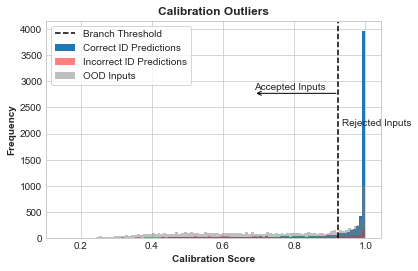

['exit_1']
(0.0, 418.95) 418.95
(0.10245457589626313, 1.0427401334047317) 0.7462011191248894


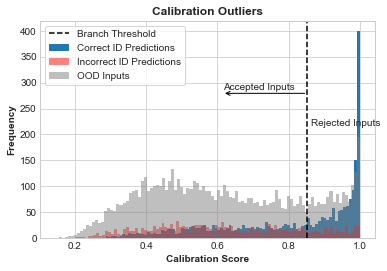

['exit_1', 'exit_2']
(0.0, 481.95) 481.95
(0.10387199372053146, 0.23806918412446978) 0.20550809428095818


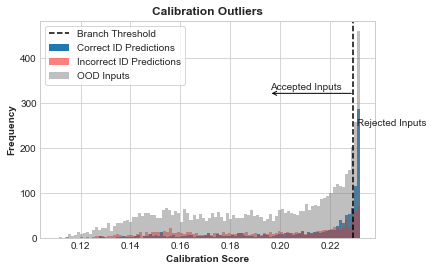

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7376  0.922861         5920          2709              5365           0.686059             0.621741
1     exit_2       4080        7291         0.7728  0.850475         1612          1504              1347           0.517330             0.432285
2  Main_exit       2468        5787         0.7852        NA         2468          5787              1260           0.298970             0.152635


In [94]:
#CE Early stopping, Calibration
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
EvaluateOOD(output_ID,output_OOD,metrics=["calibration"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
(0.0, 3597.3) 3597.3
(-0.16347832679746838, 3.4330448627471917) 0.1405024218559266


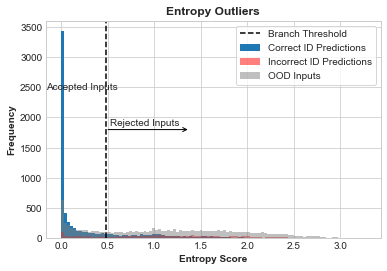

['exit_1']
(0.0, 255.15) 255.15
(-0.16296642914833231, 3.4223402425861655) 0.37160091712855997


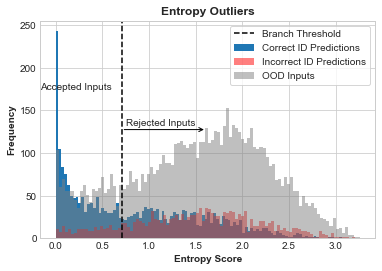

['exit_1', 'exit_2']
(0.0, 342.3) 342.3
(3.2108403205871583, 3.3249739646911616) 2.887326440811157


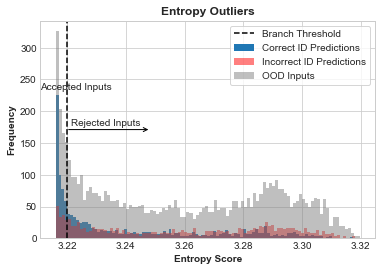

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7376  0.483807         5942          2696              5385           0.687891             0.623408
1     exit_2       4058        7304         0.7728  0.713835         1496          1280              1264           0.538905             0.455331
2  Main_exit       2562        6024         0.7852        NA         2562          6024              1313           0.298393             0.152923


In [67]:
#CE Early stopping
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
EvaluateOOD(output_ID,output_OOD,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  energy threshold:  gmean
(0.0, 477.75) 477.75
(-380.7328556060791, 94.29286079406738) -67.19997318267822


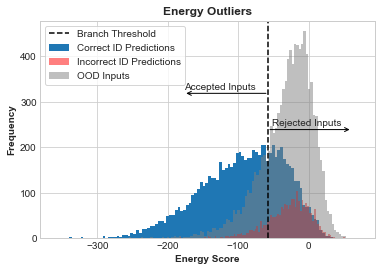

['exit_1']
(0.0, 473.55) 473.55
(-266.0547302246094, 141.96973876953126) -63.01019866943359


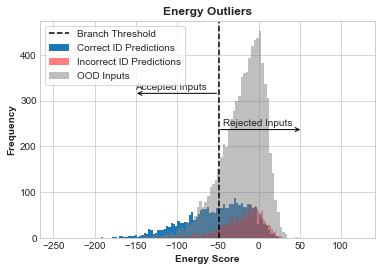

['exit_1', 'exit_2']
(0.0, 179.55) 179.55
(-2.4639753818511965, -2.401820707321167) -2.2134335947036745


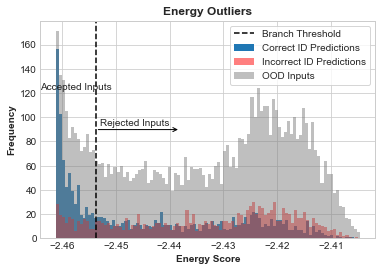

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7658 -57.770687         5612          2071              5230           0.730444             0.680724
1     exit_2       4388        7929         0.7788 -48.813225         1507          1134              1287           0.570617             0.487315
2  Main_exit       2881        6795         0.7815         NA         2881          6795              1538           0.297747             0.158950


In [100]:
#EDL Early Stopping
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
EvaluateOOD(output_ID,output_OOD,metrics=["energy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


metric:  entropy threshold:  gmean
(0.0, 5255.25) 5255.25
(-0.15951250791549687, 3.349762666225434) -0.27531649872660646


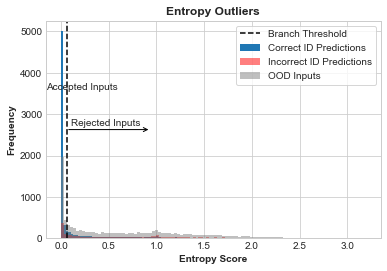

['exit_1']
(0.0, 571.2) 571.2
(-0.15715039845820594, 3.300158393324612) 0.041973410850644266


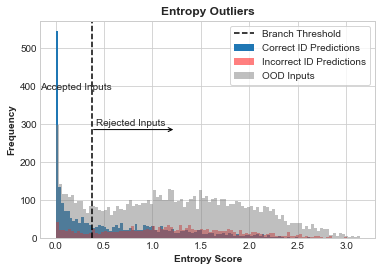

['exit_1', 'exit_2']
(0.0, 142.8) 142.8
(3.2108819484710693, 3.3240997791290283) 2.8982688188552856


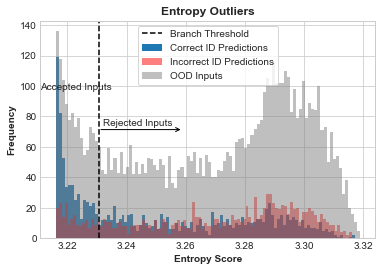

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7516   0.05966         5896          2349              5411           0.715100             0.656277
1     exit_2       4104        7651         0.7718  0.371989         1499          1396              1269           0.517789             0.438342
2  Main_exit       2605        6255         0.7815        NA         2605          6255              1369           0.294018             0.154515


In [200]:
#CE
# evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
EvaluateOOD(output_ID,output_OOD,metrics=["entropy"], threshold="gmean", exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1'])


In [53]:
#EDL
evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)


metric:  energy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7607 -48.120247         6175          2532              5643           0.709199             0.648099
1     exit_2       3825        7468         0.7649  -47.71418         1302          1231              1078           0.514015             0.425582
2  Main_exit       2523        6237         0.7815         NA         2523          6237              1304           0.288014             0.148858


In [ ]:
model.save

In [35]:
#EDL
evaluate.buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)


metric:  energy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7599  -52.28278         5871          2351              5400           0.714060             0.656775
1     exit_2       4129        7649         0.7600 -48.592064         1443          1503              1165           0.489817             0.395451
2  Main_exit       2686        6146         0.7815         NA         2686          6146              1433           0.304121             0.162251


In [22]:
#CE e15
evaluate.buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
evaluate.buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446   3.21823         5724          2424              5219           0.702504             0.640525
1     exit_2       4276        7576         0.7774  3.235315         1645          1688              1393           0.493549             0.417942
2  Main_exit       2631        5888         0.7861        NA         2631          5888              1390           0.308839             0.163165
metric:  calibration threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446  0.230435         5724          2424              5220           0.7025

In [17]:
#CE e15 2
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["calibration"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7391  0.089247         5593          2286              5131           0.709862             0.651225
1     exit_2       4407        7714         0.7679  0.421632         1737          1769              1420           0.495436             0.405020
2  Main_exit       2670        5945         0.7811        NA         2670          5945              1387           0.309925             0.160998
metric:  calibration threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7391  0.989127         5644          2345              5166           0.7064

metric:  energy threshold:  gmean


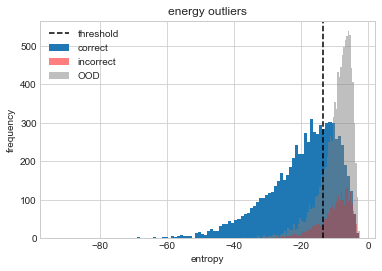

['exit_1', 'exit_2']


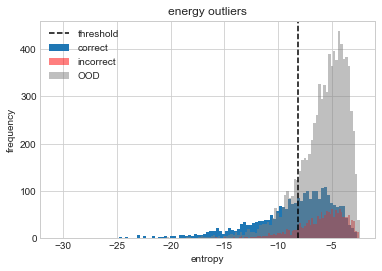

['exit_1', 'exit_2']


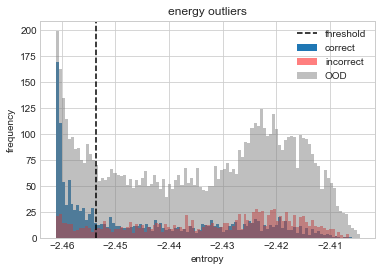

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7516 -13.319389         5666          1787              5122           0.760231             0.687240
1     exit_2       4334        8213         0.7718  -8.173308         1501          1188              1234           0.558200             0.458907
2  Main_exit       2833        7025         0.7815         NA         2833          7025              1518           0.287381             0.153987


In [20]:
#EDL + IAR e15 g100
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)


metric:  energy threshold:  gmean


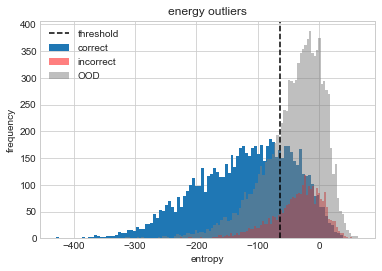

['exit_1', 'exit_2']


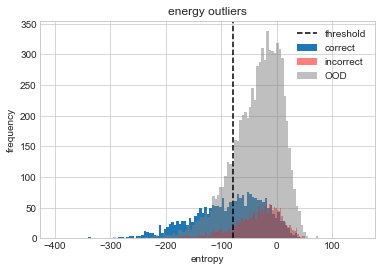

['exit_1', 'exit_2']


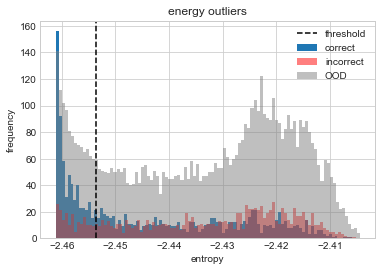

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7329 -64.166557         5894          2689              5311           0.686706             0.618781
1     exit_2       4106        7311         0.7528 -78.972603         1421          1198              1168           0.542574             0.445972
2  Main_exit       2685        6113         0.7815         NA         2685          6113              1467           0.305183             0.166742


In [300]:
#resnet_IAD +regularizer e15 g60 frozen sgd
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


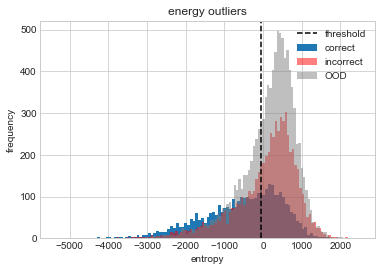

['exit_1', 'exit_2']


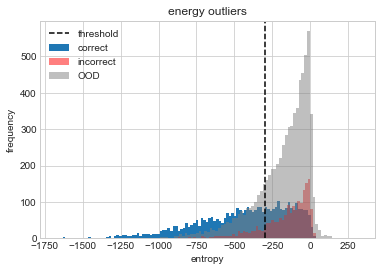

['exit_1', 'exit_2']


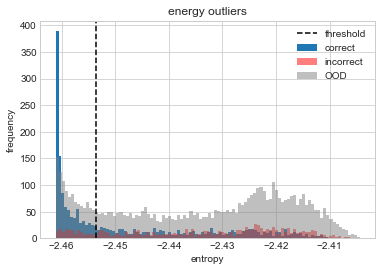

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.3681  -62.053059         4347          2965              2268           0.594502             0.310175
1     exit_2       5653        7035         0.7286 -295.136963         2686          1528              2361           0.637399             0.560275
2  Main_exit       2967        5507         0.7815          NA         2967          5507              1888           0.350130             0.222799


In [295]:
#resnet_IAD +regularizer e15 g100 frozen adam
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


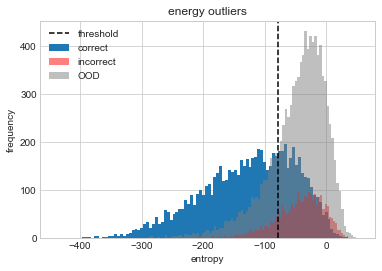

['exit_1', 'exit_2']


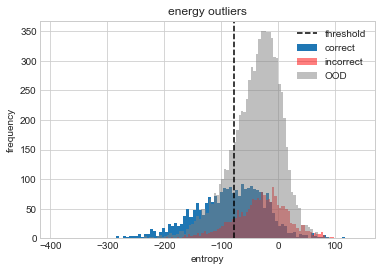

['exit_1', 'exit_2']


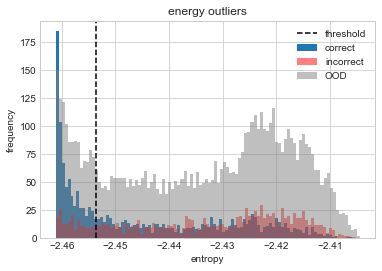

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7335 -77.866608         5557          2171              5056           0.719073             0.654244
1     exit_2       4443        7829         0.7231 -78.267838         1584          1410              1266           0.529058             0.422846
2  Main_exit       2859        6419         0.7815         NA         2859          6419              1572           0.308148             0.169433


In [290]:
#resnet_IAD +regularizer e15 g100 frozen sgd
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


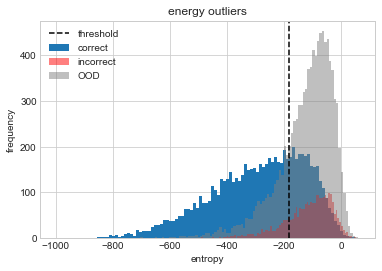

['exit_1', 'exit_2']


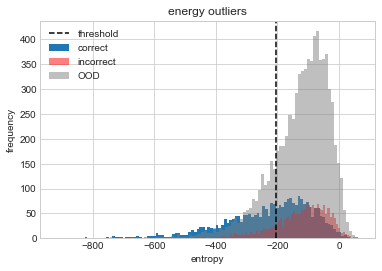

['exit_1', 'exit_2']


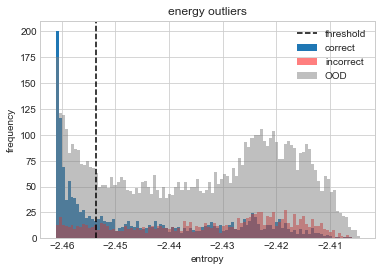

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy   Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7348 -181.679474         5571          2238              5047           0.713408             0.646306
1     exit_2       4429        7762         0.7490 -205.885025         1591          1423              1284           0.527870             0.426012
2  Main_exit       2838        6339         0.7815          NA         2838          6339              1603           0.309251             0.174676


In [274]:
#resnet_IAD no regularizer
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [247]:
#resnet_CE+EDL_
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7437  0.031959         5466          2031              5017           0.729092             0.669201
1     exit_2       4534        7969         0.7822  0.326047         1843          1790              1589           0.507294             0.437380
2  Main_exit       2691        6179         0.7815        NA         2691          6179              1458           0.303382             0.164374
metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7437 -9.587543         5662          1919              5077           0

metric:  energy threshold:  gmean


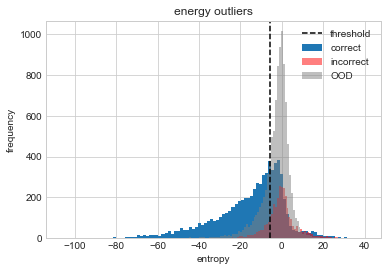

['exit_1', 'exit_2']


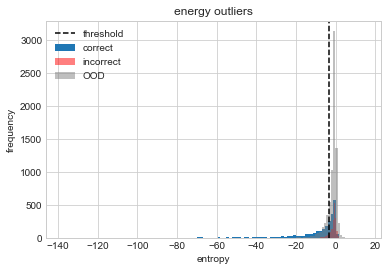

['exit_1', 'exit_2']


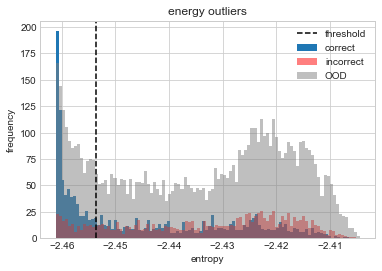

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6893 -5.487357         5270          2332              4702           0.693239             0.618521
1     exit_2       4730        7668         0.7378 -3.522316         1961          1260              1677           0.608817             0.520646
2  Main_exit       2769        6408         0.7815        NA         2769          6408              1515           0.301733             0.165087


In [239]:
#resnet_CE+EDL_
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [145]:
#resnet_CE+EDL_
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7547 -13.877436         6168          2449              5576           0.715794             0.647093
1     exit_2       3832        7551         0.7773 -23.943192         1226          1002              1027           0.550269             0.460952
2  Main_exit       2606        6549         0.7815         NA         2606          6549              1346           0.284653             0.147023


In [141]:
#CE_15_
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446  -2.46002         5724          2424              5219           0.702504             0.640525
1     exit_2       4276        7576         0.7774 -2.451184         1647          1693              1394           0.493114             0.417365
2  Main_exit       2629        5883         0.7861        NA         2629          5883              1389           0.308858             0.163181


In [135]:
#EDL 25
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7596 -78.748978         5604          1917              5100           0.745114             0.678101
1     exit_2       4396        8083         0.7711 -76.379608         1493          1115              1217           0.572469             0.466641
2  Main_exit       2903        6968         0.7815         NA         2903          6968              1591           0.294094             0.161179


In [97]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["uncert","energy","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        # print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        if plot:
            print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, exit=-1, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            if exit > 0: #if a specific exit number is specified, only output the results of that exit.
                _ID = [_ID[max(exit-1,0)]]
                _OOD = [_OOD[max(exit-1,0)]]
                exit_labels=['exit_{}'.format(exit)]

            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
             
                
                if threshold:
                    if type(threshold) is list:
                        if i >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[i]
                        print("threshold",_threshold)
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        # print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram
  
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


In [131]:
#CE e25
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576 -9.561772         5539          2048              4996           0.730065             0.658495
1     exit_2       4461        7952         0.7963 -5.523864         1853          1636              1578           0.531098             0.452279
2  Main_exit       2608        6316         0.7974        NA         2608          6316              1474           0.292246             0.165173


metric:  energy threshold:  gmean


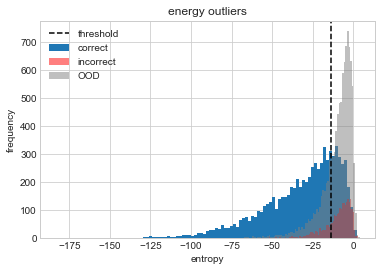

['exit_1', 'exit_2']


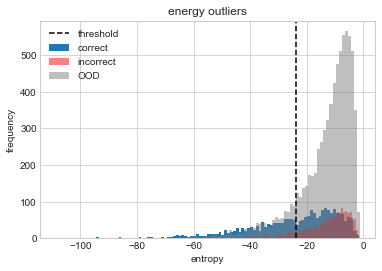

['exit_1', 'exit_2']


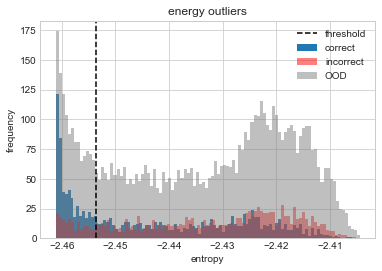

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7547 -13.877436         6168          2449              5576           0.715794             0.647093
1     exit_2       3832        7551         0.7773 -23.943192         1226          1002              1027           0.550269             0.460952
2  Main_exit       2606        6549         0.7815         NA         2606          6549              1346           0.284653             0.147023


In [123]:
#CE + EDL e15 g60
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


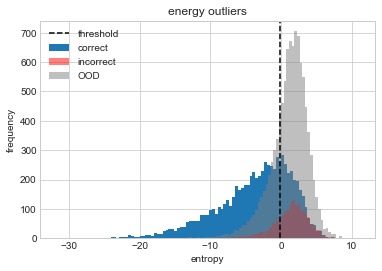

['exit_1', 'exit_2']


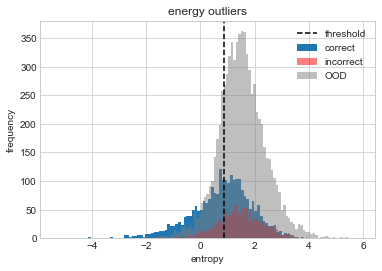

['exit_1', 'exit_2']


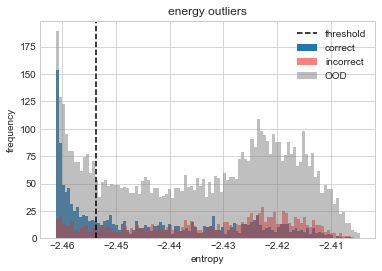

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7448  -0.11013         5908          2582              5314           0.695878             0.625913
1     exit_2       4092        7418         0.7751  0.850751         1575          1480              1235           0.515548             0.404255
2  Main_exit       2517        5938         0.7815        NA         2517          5938              1375           0.297694             0.162626


In [118]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

In [112]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7577 -10.566305         5876          2119              5362           0.734959             0.670669
1     exit_2       4124        7881         0.7786  -20.51292         1392          1086              1171           0.561743             0.472559
2  Main_exit       2732        6795         0.7815         NA         2732          6795              1459           0.286764             0.153144


metric:  energy threshold:  gmean


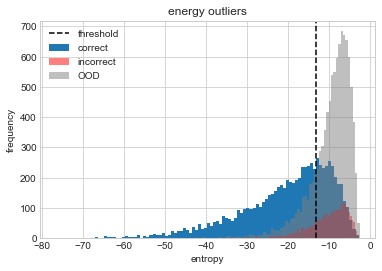

['exit_1']


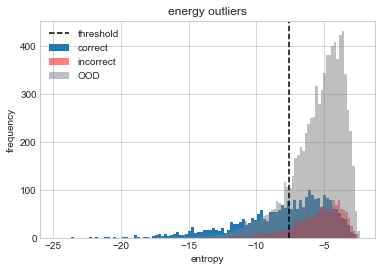

['exit_1', 'exit_2']


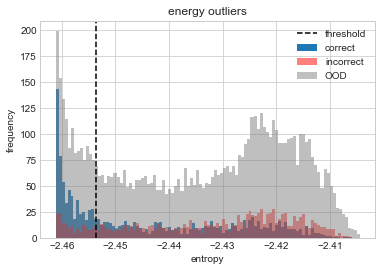

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7582 -13.270064         5779          1806              5200           0.761898             0.685564
1     exit_2       4221        8194         0.7840  -7.549907         1505          1200              1273           0.556377             0.470610
2  Main_exit       2716        6994         0.7815         NA         2716          6994              1437           0.279712             0.147992


In [98]:
# CE  g60, e15 frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean


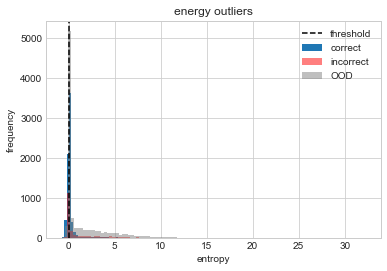

['exit_1']


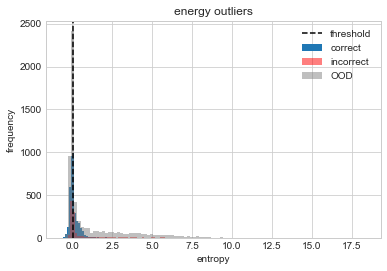

['exit_1', 'exit_2']


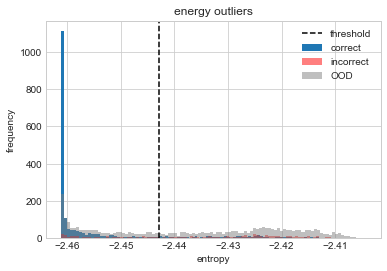

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7582   0.06052         4562          3660              3738           0.554853             0.454634
1     exit_2       5438        6340         0.7670  0.042353         2530          2690              1940           0.484674             0.371648
2  Main_exit       2908        3650         0.7815        NA         2908          3650              2166           0.443428             0.330284


In [50]:
# IAD frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.1786863064810567 Best Threshold=3.2182302474975586, G-Mean=0.7500645093945048, TPR=0.8026624902114331, FPR=0.2990867579908676


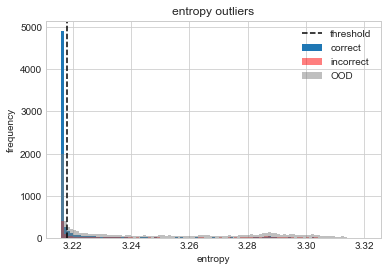

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1529445896439649 Best Threshold=3.2353153228759766, G-Mean=0.7733111525234805, TPR=0.8176100628930818, FPR=0.2685875996912786


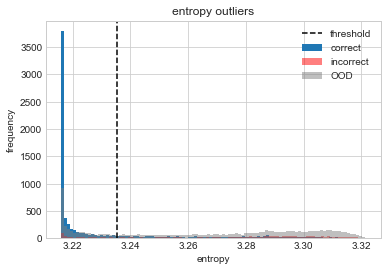

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1692145000210828 Best Threshold=3.2184739112854004, G-Mean=0.7616870657061426, TPR=0.8036465638148668, FPR=0.2780816689988551


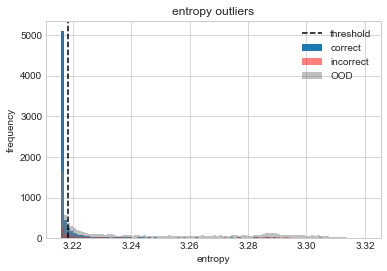

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7446   3.21823         5724          2424              5219           0.702504             0.640525
1     exit_2       4276        7576         0.7774  3.235315         1645          1688              1393           0.493549             0.417942
2  Main_exit       2631        5888         0.7861        NA         2631          5888              1390           0.308839             0.163165


In [19]:
# CE e15 not frozen
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19527929359440427 Best Threshold=-78.74897766113281, G-Mean=0.7286457511152242, TPR=0.790765391014975, FPR=0.3285939968404423


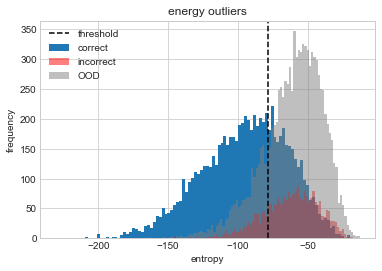

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.20056940097772982 Best Threshold=-76.37960815429688, G-Mean=0.7294623390321479, TPR=0.7907383136740935, FPR=0.3270652314874854


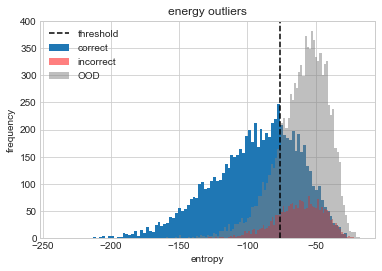

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226263522446273 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


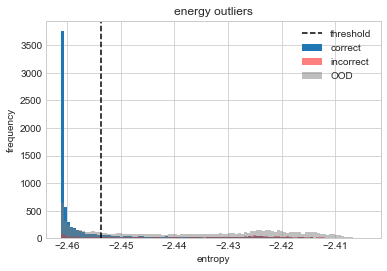

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7596 -78.748978         5604          1917              5100           0.745114             0.678101
1     exit_2       4396        8083         0.7711 -76.379608         1493          1115              1217           0.572469             0.466641
2  Main_exit       2903        6968         0.7815         NA         2903          6968              1591           0.294094             0.161179


In [24]:

buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.20402027743445605 Best Threshold=1.2943223714828491, G-Mean=0.7252133888525284, TPR=0.7576173483392808, FPR=0.3058046248230297


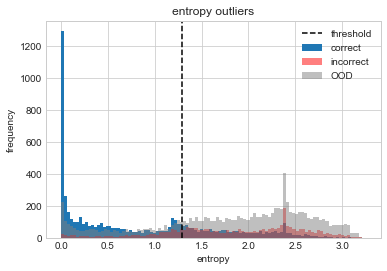

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.20111141883836078 Best Threshold=1.5177603960037231, G-Mean=0.7306939839703652, TPR=0.7635646169023348, FPR=0.3007616036786895


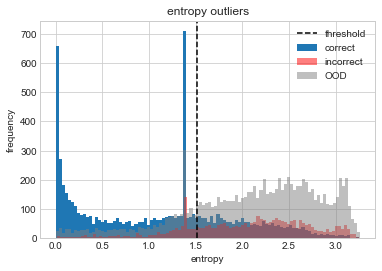

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15235583743636819 Best Threshold=3.2306787967681885, G-Mean=0.7801595473378153, TPR=0.8128146453089244, FPR=0.2511836212412028


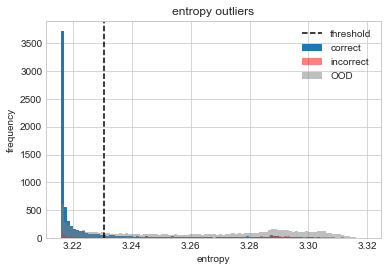

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6357  1.294322         5297          2536              4413           0.676242             0.563386
1     exit_2       4703        7464         0.6959   1.51776         1521          1241              1146           0.550688             0.414917
2  Main_exit       3182        6223         0.7815        NA         3182          6223              1894           0.338331             0.201382


In [188]:
# CE e15 frozen
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19094453348102647 Best Threshold=-76.45501708984375, G-Mean=0.7351340288876653, TPR=0.7554103715802368, FPR=0.28459806648126074


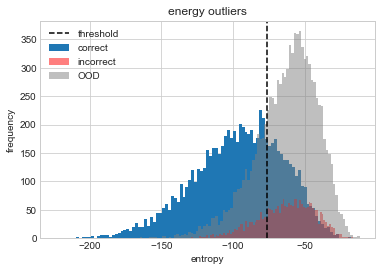

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.17976786215481294 Best Threshold=-75.03823852539062, G-Mean=0.7451050009332907, TPR=0.7856514084507042, FPR=0.2933488612836439


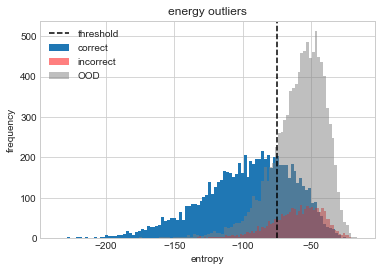

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


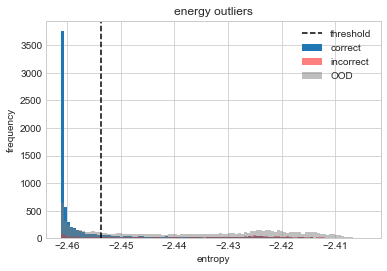

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7551 -76.455017         6002          2365              5402           0.717342             0.645632
1     exit_2       3998        7635         0.7728 -75.038239         1400          1002              1165           0.582848             0.485012
2  Main_exit       2598        6633         0.7815         NA         2598          6633              1389           0.281443             0.150471


In [178]:
# edl e15 exp_evidence, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.1947918311403509 Best Threshold=-76.9309310913086, G-Mean=0.7272239785047524, TPR=0.7458333333333333, FPR=0.29092105263157897


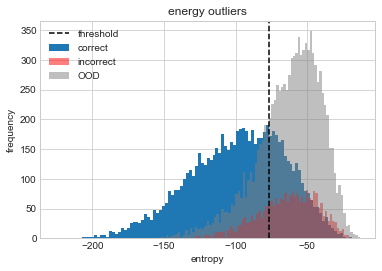

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.18559702303494882 Best Threshold=-79.9901351928711, G-Mean=0.7399044972384479, TPR=0.7869718309859155, FPR=0.30434782608695654


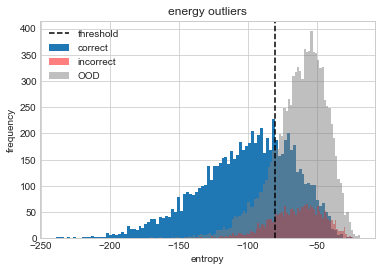

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


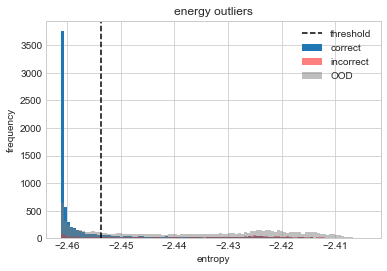

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7600 -76.930931         6000          2301              5389           0.722804             0.649199
1     exit_2       4000        7699         0.7728 -79.990135         1280           903              1049           0.586349             0.480531
2  Main_exit       2720        6796         0.7815         NA         2720          6796              1471           0.285834             0.154582


In [173]:
# edl e15 softplus, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19289383860049525 Best Threshold=-77.03716278076172, G-Mean=0.737048429573578, TPR=0.7785625259659327, FPR=0.30225207427894113


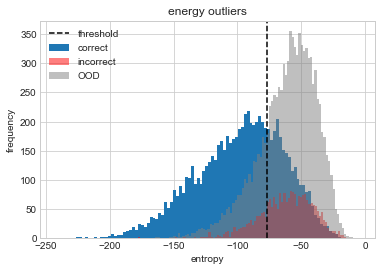

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.18008669666393967 Best Threshold=-73.35983276367188, G-Mean=0.7431628253017387, TPR=0.7609649122807017, FPR=0.2742227979274611


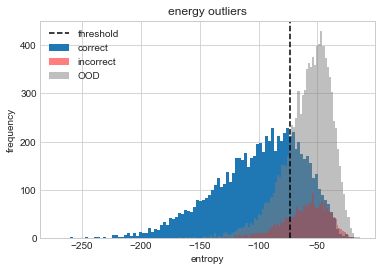

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


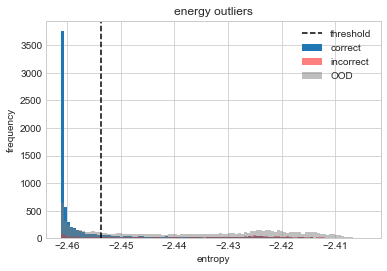

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7593 -77.037163         5832          2184              5298           0.727545             0.660928
1     exit_2       4168        7816         0.7720 -73.359833         1559          1184              1267           0.568356             0.461903
2  Main_exit       2609        6632         0.7815         NA         2609          6632              1368           0.282329             0.148036


In [163]:
# edl e15 exp_evidence, frozen then 5edl+info_reg
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19527959478629175 Best Threshold=-78.74898529052734, G-Mean=0.7286457511152242, TPR=0.790765391014975, FPR=0.3285939968404423


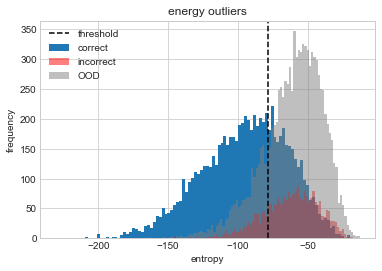

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.20056942930557298 Best Threshold=-76.3796157836914, G-Mean=0.7294623390321479, TPR=0.7907383136740935, FPR=0.3270652314874854


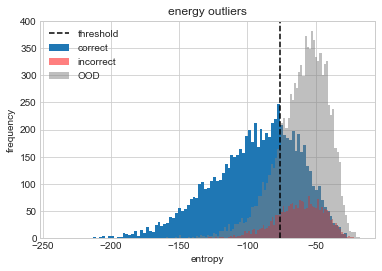

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


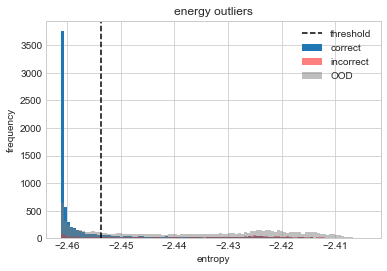

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7596 -78.748985         5604          1917              5100           0.745114             0.678101
1     exit_2       4396        8083         0.7711 -76.379616         1493          1115              1217           0.572469             0.466641
2  Main_exit       2903        6968         0.7815         NA         2903          6968              1591           0.294094             0.161179


In [156]:
#edl no KL, frozen
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.19946777791606002 Best Threshold=-77.59294128417969, G-Mean=0.7286339490995754, TPR=0.7691693290734825, FPR=0.3097652081109925


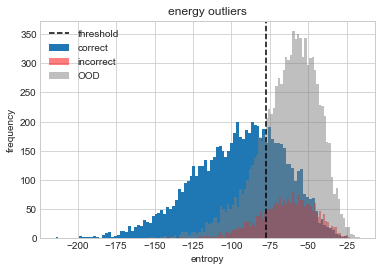

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.19199471398176154 Best Threshold=-75.72130584716797, G-Mean=0.7358854635799028, TPR=0.7662395050817499, FPR=0.2932661238206023


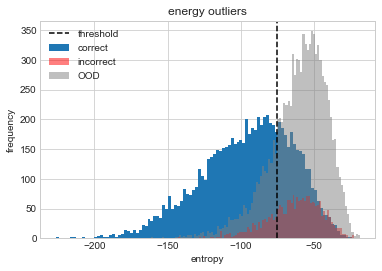

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


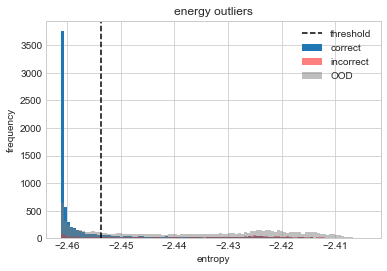

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7496 -77.592941         5753          2149              5174           0.728044             0.654771
1     exit_2       4247        7851         0.7737 -75.721306         1494          1124              1223           0.570665             0.467150
2  Main_exit       2753        6727         0.7815         NA         2753          6727              1496           0.290401             0.157806


In [149]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.15256522140459622 Best Threshold=-26.60566520690918, G-Mean=0.7649601321988799, TPR=0.7981376787495843, FPR=0.26683826683826684


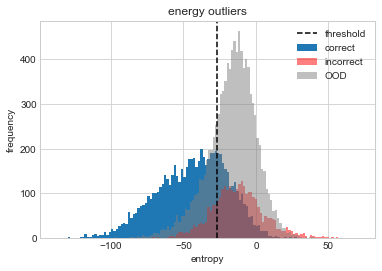

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.08950356887364799 Best Threshold=-3.1710257530212402, G-Mean=0.8255198797906981, TPR=0.8068425897514575, FPR=0.15537047673750717


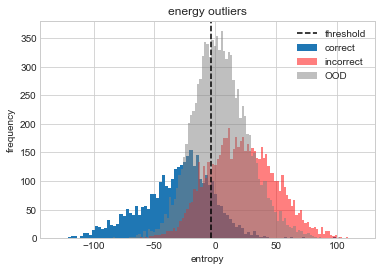

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


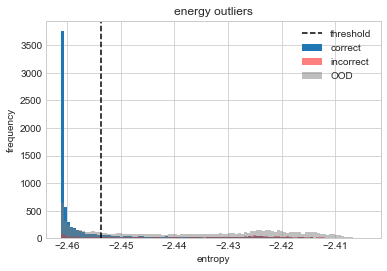

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6993 -26.605665         5735          2389              5127           0.705933             0.631093
1     exit_2       4265        7611         0.3482  -3.171026         1993          2889              1138           0.408234             0.233101
2  Main_exit       2272        4722         0.7815         NA         2272          4722              1437           0.324850             0.205462
metric:  entropy_of_expected threshold:  gmean
m entropy_of_expected
metric entropy_of_expected
entropy_of_expected  lr_auc 0.8477091515003055 Best Threshold=-2.0113717501498512e-08, G-Mean=0.7673332436377693, TPR=0.731016731016731, FPR=0.19454605919521117
['exit_1', 'exit_2']
m entropy_of_expected
metric entropy_of_expected
entropy_of_expected  lr_auc 0.9067641783395215 Best Threshold=-1.1760525177

In [141]:
# IAD loss  15epochs, branch1, frozen layers
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.16702367537843898 Best Threshold=3.2443103790283203, G-Mean=0.7614344088384057, TPR=0.7949626131444313, FPR=0.2706797157795951


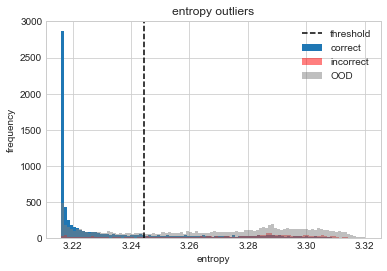

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15038814383766794 Best Threshold=3.2345285415649414, G-Mean=0.7758973758941877, TPR=0.7997243913642628, FPR=0.24721973667391026


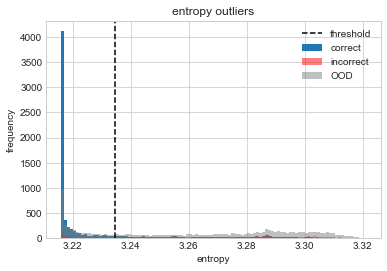

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1466219266025243 Best Threshold=3.2174553871154785, G-Mean=0.7866403806662485, TPR=0.8152534343912837, FPR=0.2409684370642667


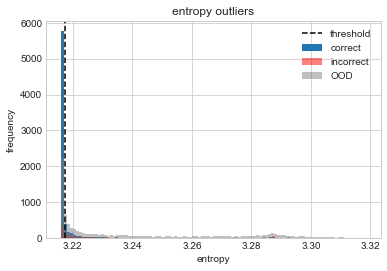

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7459   3.24431         5962          2918              5440           0.671396             0.612613
1     exit_2       4038        7082         0.7823  3.234529         1475          1491              1218           0.497303             0.410654
2  Main_exit       2563        5591         0.7889        NA         2563          5591              1406           0.314324             0.172431
metric:  entropy_of_expected threshold:  gmean
m entropy_of_expected
metric entropy_of_expected
entropy_of_expected  lr_auc 0.83299864261241 Best Threshold=-2.2855586862838075, G-Mean=0.761412824117579, TPR=0.728918085534254, FPR=0.20464384100747737
['exit_1', 'exit_2']
m entropy_of_expected
metric entropy_of_expected
entropy_of_expected  lr_auc 0.849611738727147 Best Threshold=-2.2832693074830592, G-Me

In [104]:
# entropy CE 15epochs, all softmax, not frozen layers
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.1766852605365844 Best Threshold=3.2429256439208984, G-Mean=0.7501902755239209, TPR=0.7938664596273292, FPR=0.29108297413793105


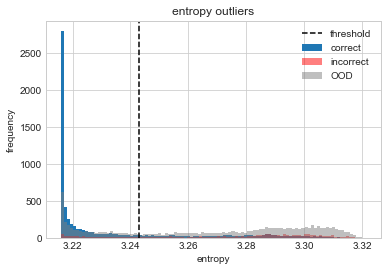

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15461249688822506 Best Threshold=3.2266781330108643, G-Mean=0.7687345033129478, TPR=0.8241758241758241, FPR=0.28297734627831717


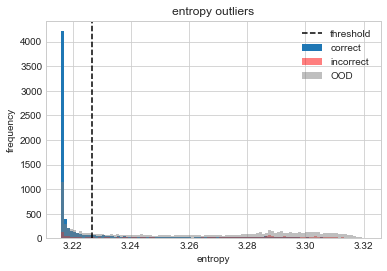

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15235583743636819 Best Threshold=3.2306787967681885, G-Mean=0.7801595473378153, TPR=0.8128146453089244, FPR=0.2511836212412028


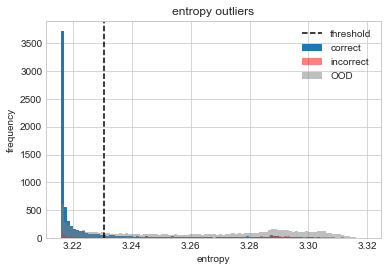

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7424  3.242926         5795          2901              5263           0.666398             0.605221
1     exit_2       4205        7099         0.7725  3.226678         1436          1400              1189           0.506347             0.419252
2  Main_exit       2769        5699         0.7815        NA         2769          5699              1547           0.326996             0.182688


In [97]:
# entropy CE 15epochs, all softmax, frozen layers
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.19588240807507207 Best Threshold=3.2769362926483154, G-Mean=0.7296618997528935, TPR=0.7229656419529837, FPR=0.2635798203178991


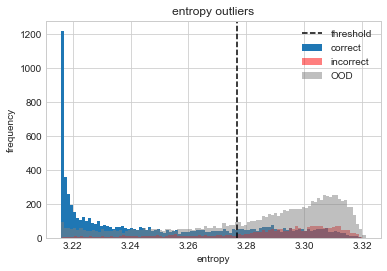

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.17224360971236213 Best Threshold=3.2574355602264404, G-Mean=0.7596162457888996, TPR=0.77579776212184, FPR=0.25622775800711745


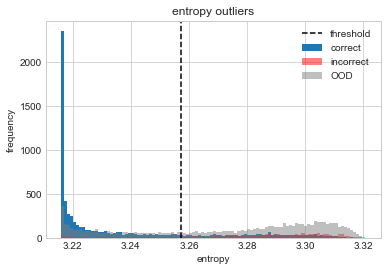

['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.15235583743636819 Best Threshold=3.2306787967681885, G-Mean=0.7801595473378153, TPR=0.8128146453089244, FPR=0.2511836212412028


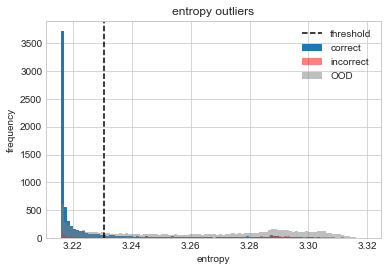

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7235  3.276936         6095          3203              5328           0.655517             0.573026
1     exit_2       3905        6797         0.7587  3.257436         1390          1608              1105           0.463642             0.368579
2  Main_exit       2515        5189         0.7815        NA         2515          5189              1425           0.326454             0.184969


In [92]:
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.16822193251760895 Best Threshold=-33.44387435913086, G-Mean=0.7592851813092546, TPR=0.8227462913655382, FPR=0.2992809659476326


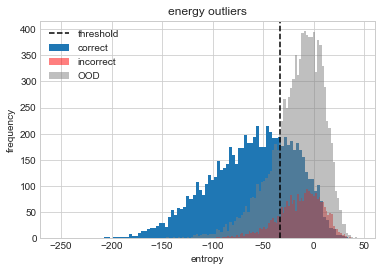

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.1722757673825635 Best Threshold=-32.28732681274414, G-Mean=0.756367860822083, TPR=0.8201941747572815, FPR=0.3024915824915825


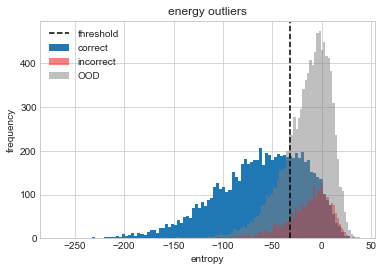

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


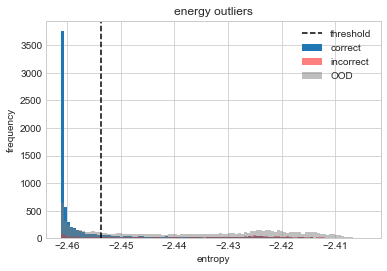

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7371 -33.443874         5632          2210              5165           0.718184             0.658633
1     exit_2       4368        7790         0.7425 -32.287327         1392          1310              1112           0.515174             0.411547
2  Main_exit       2976        6480         0.7815         NA         2976          6480              1650           0.314721             0.174492
metric:  expected_entropy threshold:  gmean
m expected_entropy
metric expected_entropy
expected_entropy  lr_auc 0.8294701837240191 Best Threshold=-2.32299378579723e-12, G-Mean=0.7606361884655466, TPR=0.7045177045177046, FPR=0.1787751996957018
['exit_1', 'exit_2']
m expected_entropy
metric expected_entropy
expected_entropy  lr_auc 0.8255422575267236 Best Threshold=-2.797577117724242e-12, G-Mean=0.756

In [78]:
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
# buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)


metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.6657947421406956 Best Threshold=-0.5544866919517517, G-Mean=0.38746925141938726, TPR=0.3264359614698537, FPR=0.5400861470056968


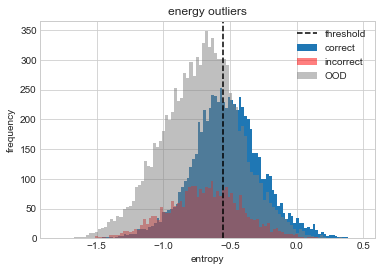

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.6103555110944361 Best Threshold=-0.5852864980697632, G-Mean=0.4240950212512322, TPR=0.3403159340659341, FPR=0.47150112866817157


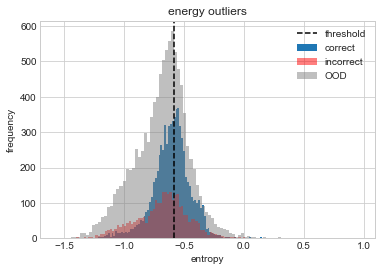

['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584


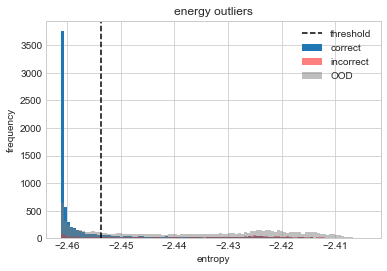

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7197 -0.554487         5199          7054              3310           0.424304             0.270138
1     exit_2       4801        2946         0.7088 -0.585286         2161          1686              1562           0.561736             0.406031
2  Main_exit       2640        1260         0.7815        NA         2640          1260              2348           0.676923             0.602051
metric:  entropy threshold:  gmean
m entropy
metric entropy
entropy  lr_auc 0.20356301092871226 Best Threshold=1.3037376403808594, G-Mean=0.7215048884677286, TPR=0.7798787013913664, FPR=0.33249965263304154
['exit_1', 'exit_2']
m entropy
metric entropy
entropy  lr_auc 0.1948862698214596 Best Threshold=0.9546273350715637, G-Mean=0.7361367729980739, TPR=0.7898351648351648, FPR=0.31391083521444696
['exit_1'

In [72]:
### IAD with info_reg but no dirichlet reg
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=True)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)


In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from numpy import sqrt, argmax
def calc_AUC(output_df,metrics=['energy'],plot=False, pos_label = 0):
    '''
    AUC calculation function for list of output dataframes
    returns a list of threshold for the gmean of each set of outputs.    
    '''
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    if type(metrics) is not list:
        metrics = [metrics]
    for metric in metrics:    
        print("metric", metric)
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(metric)
        plt.legend()
        # show the plot
        plt.show()
    return _thresholds

def buildComparePlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            # if main_exit_included:
            _ID.append(_ID.pop(0))
            _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output_ID.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        print("m",metric)
                        AUC_thresholds = calc_AUC(output_ID, metrics=metric, plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    Exit_Name.append("Main_exit")
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                    if i >= len(exit_labels):
                        exit_labels.append("exit_{}".format(i+1))
                    print(exit_labels)
                    Exit_Name.append(exit_labels[i])
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct + accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted) + len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":Exit_Name,
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)


In [53]:
### IAD with no info_reg
buildComparePlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)
buildComparePlot(output_ID, output_OOD, ["confidence_alea_uncert"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
m energy
metric energy
energy  lr_auc 0.6328433679660521 Best Threshold=-0.541270911693573, G-Mean=0.4119725361051053, TPR=0.32864820173625464, FPR=0.48357736446379107
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.6867825577407212 Best Threshold=-0.5967702865600586, G-Mean=0.37704360980545526, TPR=0.3256900212314225, FPR=0.5635055591890125
['exit_1', 'exit_2']
m energy
metric energy
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7581 -0.541271         5540          7208              3915           0.434578             0.307107
1     exit_2       4460        2792         0.7645  -0.59677         1971          1820              1472           0.519916    

metric:  entropy threshold:  gmean
entropy  lr_auc 0.17137674861731156 Best Threshold=0.0496109202504158, G-Mean=0.7534711235280429, TPR=0.783003300330033, FPR=0.27494720168954595


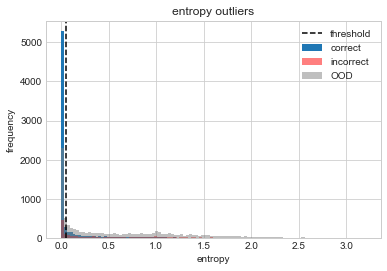

['exit_1', 'exit_2']
entropy  lr_auc 0.1578903434767735 Best Threshold=0.1522437334060669, G-Mean=0.7696279243226912, TPR=0.8247422680412371, FPR=0.28180334044957933


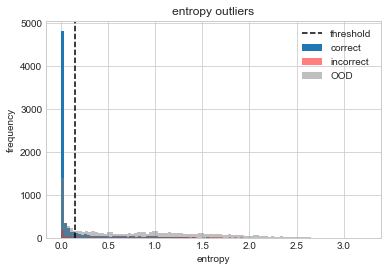

['exit_1', 'exit_2']
entropy  lr_auc 0.18006652172373638 Best Threshold=3.2170419692993164, G-Mean=0.7577669206415963, TPR=0.7502467917077986, FPR=0.2346375721093554


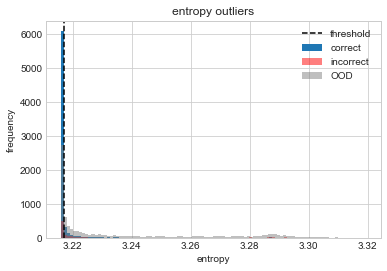

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576  0.049611         6020          2606              5493           0.697890             0.636796
1     exit_2       3980        7394         0.7963  0.152244         1539          1543              1333           0.499351             0.432511
2  Main_exit       2441        5851         0.7974        NA         2441          5851              1349           0.294380             0.162687


In [53]:
#CE entroy epoch 25
buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean", main_exit_included=True,plot=True)

metric:  expected_entropy threshold:  gmean
expected_entropy  lr_auc 0.8214007300281242 Best Threshold=-0.05152299104343559, G-Mean=0.7468468188567944, TPR=0.6969376979936642, FPR=0.19966996699669967


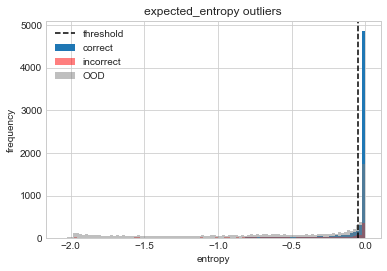

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8311578630942286 Best Threshold=-0.26161089535288395, G-Mean=0.761569944886436, TPR=0.6933316589225167, FPR=0.1634756995581738


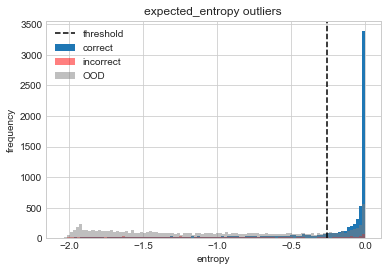

['exit_1', 'exit_2']
expected_entropy  lr_auc 0.8199329211843724 Best Threshold=-2.089558045285645, G-Mean=0.7577669206415963, TPR=0.7653624278906446, FPR=0.24975320829220138


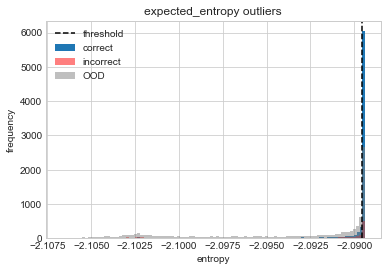

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7576 -0.051523         5764          2291              5280           0.715580             0.655493
1     exit_2       4236        7709         0.7963 -0.261611         1522          1272              1331           0.544739             0.476378
2  Main_exit       2714        6437         0.7974        NA         2714          6437              1537           0.296580             0.167960


In [51]:
### entropy 15epochs
buildCompareDistribPlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=True)

In [38]:
#### LR of 0.01, now with p=6

buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["expected_entropy"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["entropy_of_expected"], "gmean", main_exit_included=True,plot=False)
buildCompareDistribPlot(output_ID, output_OOD, ["confidence_alea_uncert"], "gmean", main_exit_included=True,plot=False)

metric:  energy threshold:  gmean
energy  lr_auc 0.5805526115131528 Best Threshold=-0.4993135929107666, G-Mean=0.45764345776277954, TPR=0.32285471537807986, FPR=0.35129479466387653
['exit_1', 'exit_2']
energy  lr_auc 0.60139981474915 Best Threshold=-0.6014286875724792, G-Mean=0.4400308717641781, TPR=0.4414145717937793, FPR=0.5613484907879263
['exit_1', 'exit_2']
energy  lr_auc 0.15226272306820626 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.7646 -0.499314         6555          7528              4960           0.465455             0.352198
1     exit_2       3445        2472         0.7653 -0.601429         1394          1408              1000           0.497502             0.356888
2  Main_exit       2051        1064         0.7815  

In [77]:
def calc_auc_OOD(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True, OOD_rate=[.1,.2,.5,1], plot=True,exit_labels=['exit_1']):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            Exit_Name=[]
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for rate in OOD_rate:
                # print(int(min((len(_output_ID) * i),len(_output_ID))))
                print("OOD size",rate)
                _OOD_frac=[]
                Exit_Name=[]
                rollOver_ID_indices = pd.Index([])
                rollOver_OOD_indices = pd.Index([])
                Input_ID=[]
                Input_OOD=[]
                Accepted_list =[]
                Accepted_ID_list = []
                Accepted_OOD_list = []
                Acceptance_correct =[]
                Input_predictions =[]
                Accepted_Ratio_list=[]
                Accepted_Accuracy_list=[]
                # Branch_cost =[17443270,29419724,132134023] #flat exit costs
                # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

                # Base_cost = 112698838
                Branch_flops = []
                Thresholds=[]
                Test_accuracy =[]
                Rollover_accuracy=[]
                Results=[]
                for i, output in enumerate(_OOD):
                    
                    amount = min(len(_ID[i]) * rate,len(_ID[i]))
                    # print("len",amount)
                    _OOD_frac.append(_OOD[i].iloc[0:int(amount)])
                    # print(len(_OOD_frac[i]),len(_ID[i]))
                # _df = pd.concat([_ID,_OOD], ignore_index=True)
                # y_true = np.int32(_df['outlier'])
                for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD_frac)): 
                    Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))

                    legend = ["threshold","correct","incorrect", "OOD"]
                    Correct = output_ID.loc[(output_ID['correct'] == True)]
                    Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                    if plot:
                        _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                        _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                        _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram


                    if threshold:
                        if type(threshold) is list:
                            if j >= len(threshold): #no threshold in the array so treat as None.
                                continue
                            _threshold = threshold[j]
                        else:
                            _threshold = threshold
                        if _threshold == "mean":
                            # _threshold = np.array(ID[metric]).mean()
                            Correct = output_ID.loc[(output_ID["correct"] == True)]
                            _threshold = np.array(Correct[metric]).mean()
                        if _threshold == "gmean":
                            AUC_thresholds = evaluate.calc_AUC(output_ID, metrics=metrics,plot = False)
                            _threshold = AUC_thresholds[j]
                        if _threshold == "PR_AUC":
                            precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                            _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                        else:
                            _threshold = np.float32(_threshold)

                    if len(rollOver_ID_indices)>0:
                        # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                        output_ID = output_ID.iloc[rollOver_ID_indices]
                    if len(rollOver_OOD_indices)>0:
                        # if plot:
                        # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                        output_OOD = output_OOD.iloc[rollOver_OOD_indices]

                    if plot:
                        plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                        plt.title(metric + " outliers")
                        plt.legend(legend)
                        plt.xlabel("entropy")
                        plt.ylabel("frequency")
                        plt.show()
                    if main_exit_included and i == len(_ID)-1 :
                        Exit_Name.append("Main_exit")
                        _threshold
                        if plot:
                            print("main_exit")
                        OOD_accepted = output_OOD
                        OOD_rejected = None
                        ID_accepted = output_ID
                        ID_rejected = None
                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = None
                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = None
                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        _threshold = "NA"
                        ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                        # if metric in lessThanMetrics:
                            # _threshold = math.inf
                        # else:
                            # _threshold = -math.inf
                    # print(_threshold)
                    else:
                        if metric in lessThanMetrics: ## metrics that require less than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                        else: ### metrics that require greater than metric
                            OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                            OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                            ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                            ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                            accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                            rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                            accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                            rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                            accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                            overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                            # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                            # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                            # print("overall Accepted acc:",(overall_accepted_acc))

                            # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                            # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                            # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                        rollOver_ID_indices = ID_rejected.index
                        rollOver_OOD_indices = OOD_rejected.index
                        if i >= len(exit_labels):
                            exit_labels.append("exit_{}".format(i+1))
                        print(exit_labels)
                        Exit_Name.append(exit_labels[i])
                    Thresholds.append(_threshold)

                    Results.append(accepted_correct +accepted_incorrect)
                    Input_ID.append(len(output_ID))
                    Input_OOD.append(len(output_OOD))
                    Accepted_ID_list.append(len(ID_accepted))
                    Accepted_OOD_list.append(len(OOD_accepted))
                    Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                    Acceptance_correct.append(len(accepted_correct))
                    Accepted_Accuracy_list.append(overall_accepted_acc)
                df = pd.DataFrame({
                "Exit_Name":Exit_Name,
                "ID_Inputs":Input_ID,
                "OOD_Inputs":Input_OOD,
                "Test_Accuracy":Test_accuracy,
                # "RollOver_Accuracy":Rollover_accuracy,
                "Threshold":Thresholds,
                "Accepted ID":Accepted_ID_list,
                "Accepted OOD":Accepted_OOD_list,

                "Accepted_Correct":Acceptance_correct,
                "Accepted_ID_Ratio":Accepted_Ratio_list,
                "Acceptance_Accuracy":Accepted_Accuracy_list,

                # "Flops":Branch_flops,
                # "Cost Ratio":,                                  
                              })
                with pd.option_context('expand_frame_repr', False):
                    print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))


In [78]:
#entropy e15 not frozen
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  entropy threshold:  gmean
OOD size 0.1
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7376  0.483807         5942           279              5385           0.955152             0.865616
1     exit_2       4058         721         0.7728  0.713833         1496           131              1264           0.919484             0.776890
2  Main_exit       2562         590         0.7852        NA         2562           590              1313           0.812817             0.416561
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.7376  0.483807         5942           518              5385           0.919814           

In [82]:
#EDL + IAR e26
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7658 -57.770653         5612           206              5230           0.964593             0.898934
1     exit_2       4388         794         0.7788 -48.813324         1507           115              1287           0.929100             0.793465
2  Main_exit       2881         679         0.7815         NA         2881           679              1538           0.809270             0.432022
OOD size 0.2
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        2000         0.7658 -57.770653         5612           414              5230           0.93

In [25]:
#EDL +IAR e15, g100
calc_auc_OOD(output_ID, output_OOD, ["energy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


metric:  energy threshold:  gmean
OOD size 0.1
energy  lr_auc 0.19856022128637651 Best Threshold=-13.319389343261719, G-Mean=0.7297319698653539, TPR=0.7814009661835749, FPR=0.3185204896221394
['exit_1']
energy  lr_auc 0.18963091844667382 Best Threshold=-8.173308372497559, G-Mean=0.7352324882947289, TPR=0.7646801051709027, FPR=0.29308110909562063
['exit_1', 'exit_2']
energy  lr_auc 0.15226281091194982 Best Threshold=-2.453615665435791, G-Mean=0.7800928869756364, TPR=0.8128146453089244, FPR=0.25131158029430584
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000        1000         0.7516 -13.319389         5666           187              5122           0.968051             0.875107
1     exit_2       4334         813         0.7718  -8.173308         1501           114              1234           0.929412             0.764087
2  Main_exit       2833         699         0

In [76]:
calc_auc_OOD(output_ID, output_OOD, ["entropy"], "gmean",OOD_rate=[.1,.2,.5,1],plot=False)


TypeError: calc_auc_OOD() got multiple values for argument 'OOD_rate'

In [28]:
# print(output_ID.head())
# print(output_OOD_svhn.head())

In [29]:
from numpy import sqrt
from numpy import argmax
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve

from matplotlib import pyplot
def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()
    return _thresholds




metric:  energy threshold:  gmean
energy  lr_auc 0.19554773669405584 Best Threshold=-36.46367263793945, G-Mean=0.7322403176176772, TPR=0.7958860759493671, FPR=0.3263157894736842
['exit_1']
5254 inputs accepted 4608 Correct


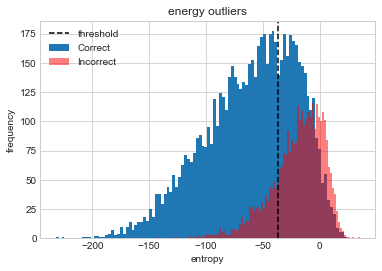

-----------------
energy  lr_auc 0.17401491388054582 Best Threshold=-36.54698181152344, G-Mean=0.7470667840621376, TPR=0.7621028744326778, FPR=0.2676726481783578
rollover enabled, 4746 predictions provided
['exit_1', 'exit_2']
1591 inputs accepted 1278 Correct


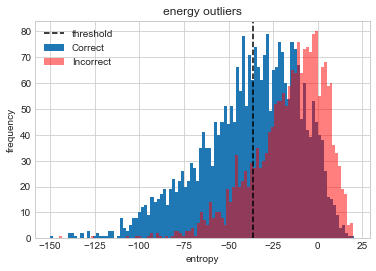

-----------------
energy  lr_auc 0.155865546303466 Best Threshold=-2.4609506130218506, G-Mean=0.7732734597462088, TPR=0.8307984790874525, FPR=0.28026849037487334
rollover enabled, 3155 predictions provided
main_exit
3155 inputs accepted 1861 Correct


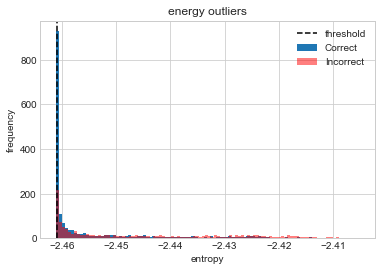

-----------------
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -36.463673      5254              4608         0.52540             0.877046
1     exit_2         4746         0.7356           0.583439 -36.546982      1591              1278         0.33523             0.803268
2  Main_exit         3155         0.7896           0.589857  -2.460951      3155              1861         1.00000             0.589857


In [45]:
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=True)


In [19]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)


metric:  energy threshold:  PR_AUC
['exit_1']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6186           0.618600 -23.827610      3815              3233        0.381500             0.847444
1     exit_2         6185         0.6842           0.581568 -28.898783      1039               946        0.167987             0.910491
2  Main_exit         5146         0.7229           0.578119  -2.457023      5146              2975        1.000000             0.578119


In [46]:
evaluate.calculateBranching(output_ID,threshold="PR_AUC",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="mean",metrics=["energy"],main_exit_included=True,plot=False)
evaluate.calculateBranching(output_ID,threshold="gmean",metrics=["energy"],main_exit_included=True,plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -62.067787      3161              2989        0.316100             0.945587
1     exit_2         6839         0.7356           0.638690 -85.762321       551               528        0.080567             0.958258
2  Main_exit         6288         0.7896           0.694338  -2.405045      6288              4366        1.000000             0.694338
metric:  energy threshold:  mean
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy
0     exit_1        10000         0.6840           0.684000 -60.051956      3304              3103        0.330400             0.939165
1     exit_2         6696       

metric:  uncert
4084 inputs accepted 3284 Correct


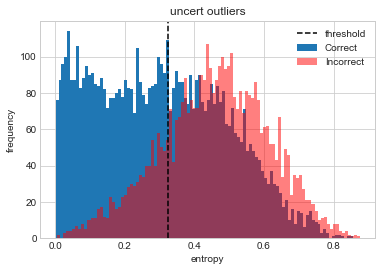

-----------------
rollover enabled, 5916 predictions provided
534 inputs accepted 500 Correct


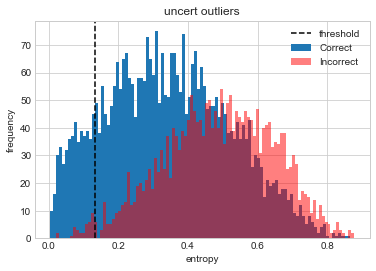

-----------------
rollover enabled, 5382 predictions provided
main_exit
5382 inputs accepted 3859 Correct


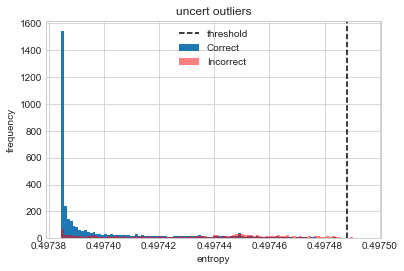

-----------------
  Exit_Name  Predictions  Test_Accuracy  RollOver_Accuracy  Threshold  Accepted  Accepted_Correct  Accepted_Ratio  Acceptance_Accuracy         Flops
0   branch1        10000         0.5917           0.591700   0.323077      4084              3284        0.408400             0.804114   71238314680
1   branch2         5916         0.7139           0.613083   0.134503       534               500        0.090264             0.936330   15710132616
2      main         5382         0.8091           0.717020   0.497488      5382              3859        1.000000             0.717020  711145311786
thresholds [0.32307744, 0.1345032, 0.4974882]
input_predictions [10000, 5916, 5382]
Accepted_list [4084, 534, 5382]
Acceptance_correct [3284, 500, 3859]
overall Accuracy 0.7643
branch_cost [71238314680, 15710132616, 711145311786]
base cost:  798093759082  total cost: 1126988380000
cost difference:  0.7081650292454656


In [34]:
calculateBranching(output_ID,threshold="PR_AUC",metrics=["uncert"],plot=)

In [19]:
import math
def buildCompareDistribPlot(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],main_exit_included=True,plot=True):
        lessThanMetrics = ["energy","uncert","entropy"]
        if type(metrics ) is not list:
            metrics = [metrics]
        for j, metric in enumerate(metrics):
            print("metric: ", metric, "threshold: ",threshold)
            rollOver_ID_indices = pd.Index([])
            rollOver_OOD_indices = pd.Index([])
            
            _ID = ID.copy()
            _OOD = OOD.copy()
                # print(_branch_predictions)
            if main_exit_included:
                _ID.append(_ID.pop(0))
                _OOD.append(_OOD.pop(0))
            Accepted_df = pd.DataFrame()
            Input_ID=[]
            Input_OOD=[]
            Accepted_list =[]
            Accepted_ID_list = []
            Accepted_OOD_list = []
            Acceptance_correct =[]
            Input_predictions =[]
            Accepted_Ratio_list=[]
            Accepted_Accuracy_list=[]
            # Branch_cost =[17443270,29419724,132134023] #flat exit costs
            # Branch_cost =[482376,1517643,80095445,114361924,112698838] #Conv2d exit costs

            # Base_cost = 112698838
            Branch_flops = []
            Thresholds=[]
            Test_accuracy =[]
            Rollover_accuracy=[]
            Results=[]
            for i, (output_ID, output_OOD) in enumerate(zip(_ID, _OOD)): 
                Test_accuracy.append(len(output_ID.loc[(output_ID["correct"] == True)])/len(output_ID))
                
                legend = ["threshold","correct","incorrect", "OOD"]
                Correct = output_ID.loc[(output_ID['correct'] == True)]
                Incorrect = output_ID.loc[(output_ID['correct'] == False)]
                if plot:
                    _ = plt.hist(Correct[metric].tolist(), bins=100)  # arguments are passed to np.histogram
                    _ = plt.hist(Incorrect[metric].tolist(), bins=100,color ="red", alpha = 0.5)  # arguments are passed to np.histogram
                    _ = plt.hist(output_OOD[metric].tolist(), bins=100,color="grey",alpha=0.5)  # arguments are passed to np.histogram

                
                if threshold:
                    if type(threshold) is list:
                        if j >= len(threshold): #no threshold in the array so treat as None.
                            continue
                        _threshold = threshold[j]
                    else:
                        _threshold = threshold
                    if _threshold == "mean":
                        # _threshold = np.array(ID[metric]).mean()
                        Correct = output.loc[(output_ID["correct"] == True)]
                        _threshold = np.array(Correct[metric]).mean()
                    if _threshold == "gmean":
                        AUC_thresholds = calc_AUC(output_ID, metrics=metrics,plot = False)
                        _threshold = AUC_thresholds[j]
                    if _threshold == "PR_AUC":
                        precision_, recall_, proba = precision_recall_curve(output_ID['correct'], output_ID[metric])
                        _threshold = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
                    else:
                        _threshold = np.float32(_threshold)

                if len(rollOver_ID_indices)>0:
                    # print("rollover enabled, {} ID predictions provided".format(len(rollOver_ID_indices)))
                    output_ID = output_ID.iloc[rollOver_ID_indices]
                if len(rollOver_OOD_indices)>0:
                    # if plot:
                    # print("rollover enabled, {} OOD predictions provided".format(len(rollOver_OOD_indices)))
                    output_OOD = output_OOD.iloc[rollOver_OOD_indices]
                    
                if plot:
                    plt.axvline(x=_threshold, color='k', linestyle='--',label="threshold")
                    plt.title(metric + " outliers")
                    plt.legend(legend)
                    plt.xlabel("entropy")
                    plt.ylabel("frequency")
                    plt.show()
                if main_exit_included and i == len(_ID)-1 :
                    _threshold
                    if plot:
                        print("main_exit")
                    OOD_accepted = output_OOD
                    OOD_rejected = None
                    ID_accepted = output_ID
                    ID_rejected = None
                    accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                    rejected_correct = None
                    accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                    rejected_incorrect = None
                    accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                    overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                    _threshold = "NA"
                    ### make a threshold that accepts everything, if less than, set to inf, if greater than, set to neg inf?
                    # if metric in lessThanMetrics:
                        # _threshold = math.inf
                    # else:
                        # _threshold = -math.inf
                # print(_threshold)
                else:
                    if metric in lessThanMetrics: ## metrics that require less than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() <= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() > _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] <= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] > _threshold)] #FN


                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN

                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
                    else: ### metrics that require greater than metric
                        OOD_accepted = output_OOD.loc[(output_OOD[metric].tolist() >= _threshold)] #FP
                        OOD_rejected = output_OOD.loc[(output_OOD[metric].tolist() < _threshold)] #TN
                        ID_accepted = output_ID.loc[(output_ID[metric] >= _threshold)] #TP
                        ID_rejected = output_ID.loc[(output_ID[metric] < _threshold)] #FN

                        accepted_correct = ID_accepted.loc[(ID_accepted["correct"] == True )] #TP
                        rejected_correct = ID_rejected.loc[(ID_rejected["correct"] == True)]  #FN

                        accepted_incorrect = ID_accepted.loc[(ID_accepted[metric] ==False)] #FP
                        rejected_incorrect = ID_rejected.loc[(ID_rejected[metric] ==False)] #TN



                        accepted_ID_acc = len(accepted_correct) / (len( ID_accepted))
                        overall_accepted_acc = len(accepted_correct) / (len( ID_accepted) + len(OOD_accepted))
                        # print("OOD accepted:", len(OOD_accepted),": with threshold:",_threshold )
                        # print("ID accepted:", len(ID_accepted), ":with acc:",(accepted_ID_acc))
                        # print("overall Accepted acc:",(overall_accepted_acc))

                        # print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() >= _threshold)]), "out of ", len(OOD))
                        # print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] >= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] >= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] >= _threshold)]))
                        # print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] >= _threshold)])+len(OOD.loc[(OOD[metric] >= _threshold)])))
                    rollOver_ID_indices = ID_rejected.index
                    rollOver_OOD_indices = OOD_rejected.index
                
                Thresholds.append(_threshold)
                
                Results.append(accepted_correct +accepted_incorrect)
                Input_ID.append(len(output_ID))
                Input_OOD.append(len(output_OOD))
                Accepted_ID_list.append(len(ID_accepted))
                Accepted_OOD_list.append(len(OOD_accepted))
                Accepted_Ratio_list.append(len(ID_accepted)/(len(ID_accepted)+ len(OOD_accepted)))
                Acceptance_correct.append(len(accepted_correct))
                Accepted_Accuracy_list.append(overall_accepted_acc)
            df = pd.DataFrame({
            "Exit_Name":["branch1","branch2","main"],
            "ID_Inputs":Input_ID,
            "OOD_Inputs":Input_OOD,
            "Test_Accuracy":Test_accuracy,
            # "RollOver_Accuracy":Rollover_accuracy,
            "Threshold":Thresholds,
            "Accepted ID":Accepted_ID_list,
            "Accepted OOD":Accepted_OOD_list,
                
            "Accepted_Correct":Acceptance_correct,
            "Accepted_ID_Ratio":Accepted_Ratio_list,
            "Acceptance_Accuracy":Accepted_Accuracy_list,

            # "Flops":Branch_flops,
            # "Cost Ratio":,                                  
                          })
            with pd.option_context('expand_frame_repr', False):
                print (df)
                # print("TPR_ID-OOD",len(ID_accepted)/(len(ID_accepted) + len(ID_rejected)))
                # print("TPR_acc",len(accepted_correct)/(len(accepted_correct) + len(rejected_correct)))
                # if len(OOD) > 0:
                #     print("FPR_ID-OOD",len(OOD_accepted)/(len(OOD_accepted) + len(OOD_rejected)))
                # else: 
                #     print("FPR for OOD is div by zero, was OOD included?")
                # print("FPR_acc",len(accepted_incorrect)/(len(accepted_incorrect) + len(rejected_incorrect)))

metric:  energy threshold:  gmean
energy  lr_auc 0.20934625649910502 Best Threshold=-26.05022621154785, G-Mean=0.7188099579149927, TPR=0.7446220036877689, FPR=0.3061073228579899


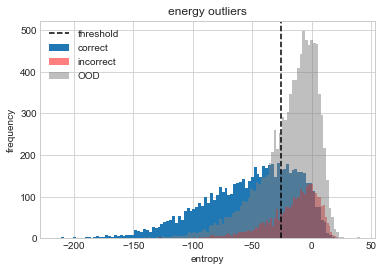

['exit_1', 'exit_2']
energy  lr_auc 0.18275134293911388 Best Threshold=-36.14278793334961, G-Mean=0.746117674450855, TPR=0.7806826434277415, FPR=0.28691691967982336


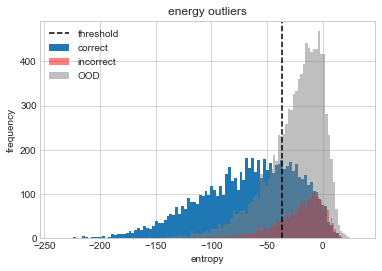

['exit_1', 'exit_2']
energy  lr_auc 0.155865546303466 Best Threshold=-2.4609506130218506, G-Mean=0.7732734597462088, TPR=0.8307984790874525, FPR=0.28026849037487334


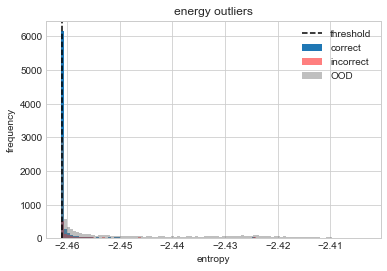

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6746 -26.050226         5513          3061              4681            0.64299             0.545953
1     exit_2       4487        6939         0.7246 -36.142788         1607          1395              1269            0.53531             0.422718
2  Main_exit       2880        5544         0.7896         NA         2880          5544              1777            0.34188             0.210945


In [54]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "gmean",plot=True)



# buildCompareDistribPlot(output_ID, output_OOD, ["calibration"], "PR_AUC",plot=False)

metric:  entropy threshold:  gmean
entropy  lr_auc 0.21129531635653595 Best Threshold=1.0471251643551227e-10, G-Mean=0.7233703511470386, TPR=0.7795601552393273, FPR=0.3287693561532192


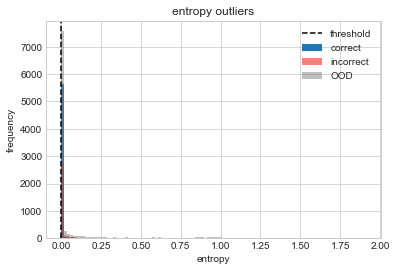

['exit_1', 'exit_2']
entropy  lr_auc 0.1756078781813878 Best Threshold=1.2474576926990721e-11, G-Mean=0.759633998285489, TPR=0.7934202726733847, FPR=0.2727135526712949


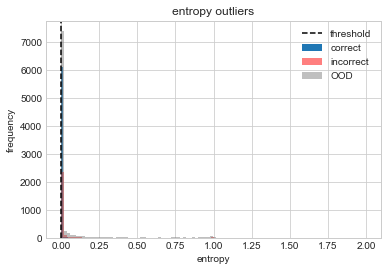

['exit_1', 'exit_2']
entropy  lr_auc 0.14753289881823703 Best Threshold=3.2191600799560547, G-Mean=0.7761441923966569, TPR=0.7820577800304105, FPR=0.2297246792076741


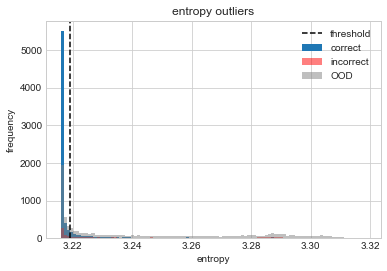

main_exit
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6135       0.0         4971          2905              4118           0.631158             0.522854
1     exit_2       5029        7095         0.6626       0.0         1613          1370              1217           0.540731             0.407979
2  Main_exit       3416        5725         0.8027        NA         3416          5725              2304           0.373701             0.252051


In [32]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["entropy"], "gmean",plot=True)

In [26]:
evaluate.buildCompareDistribPlot(output_ID, output_OOD, ["energy"], "PR_AUC",plot=False)

metric:  energy threshold:  PR_AUC
['exit_1', 'exit_2']
['exit_1', 'exit_2']
   Exit_Name  ID_Inputs  OOD_Inputs  Test_Accuracy  Threshold  Accepted ID  Accepted OOD  Accepted_Correct  Accepted_ID_Ratio  Acceptance_Accuracy
0     exit_1      10000       10000         0.6186  -23.82761         3815          1707              3233           0.690873             0.585476
1     exit_2       6185        8293         0.6842 -28.898783         1039           464               946           0.691284             0.629408
2  Main_exit       5146        7829         0.7229         NA         5146          7829              2975           0.396609             0.229287


energy  lr_auc 0.4420954222816514 Best Threshold=0.6266776323318481, G-Mean=0.5392735832037918, TPR=0.5870374968959523, FPR=0.5046040515653776
uncert  lr_auc 0.6111945439769917 Best Threshold=0.6424882411956787, G-Mean=0.4214332071208849, TPR=0.4315867891730817, FPR=0.58848150008371
entropy  lr_auc 0.23908319995230584 Best Threshold=1.1779698133468628, G-Mean=0.6944930195760037, TPR=0.7442264713185994, FPR=0.3519169596517663
calibration  lr_auc 0.767563131018646 Best Threshold=0.6875507235527039, G-Mean=0.7005592552981639, TPR=0.6845806127574083, FPR=0.28308914824931714


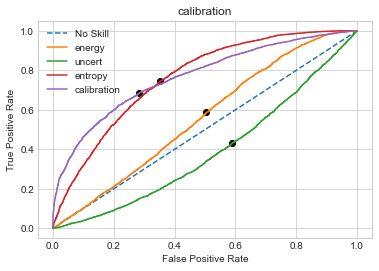

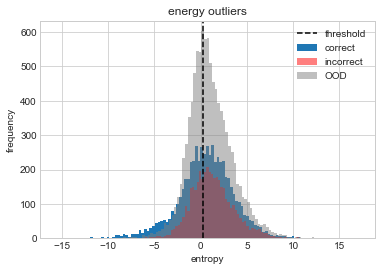

OOD accepted: 3935 : with threshold: 0.2630725
ID accepted: 4028 :with acc: 0.6519364448857994
overall Accepted acc: 0.32977521034785884
TPR_ID-OOD 0.4028
TPR_acc 0.43964506947932364
FPR_ID-OOD 0.3935
FPR_acc 0.3481499875838093


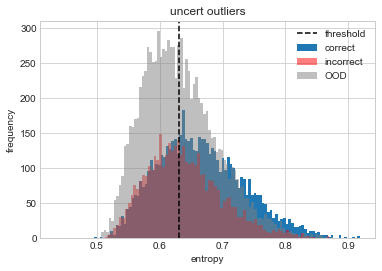

OOD accepted: 5368 : with threshold: 0.6314874
ID accepted: 4028 :with acc: 0.5034756703078451
overall Accepted acc: 0.21583652618135377
TPR_ID-OOD 0.4028
TPR_acc 0.33952787543947766
FPR_ID-OOD 0.5368
FPR_acc 0.4966476285075739


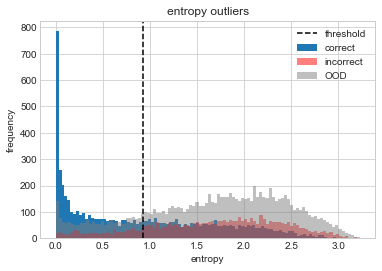

OOD accepted: 1908 : with threshold: 0.92764586
ID accepted: 4028 :with acc: 0.8331678252234359
overall Accepted acc: 0.5653638814016172
TPR_ID-OOD 0.4028
TPR_acc 0.5618617110329818
FPR_ID-OOD 0.1908
FPR_acc 0.16687360317854483


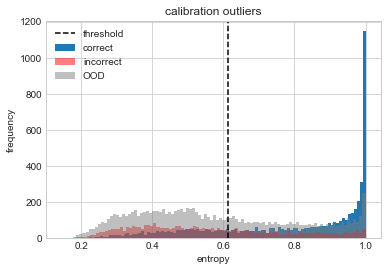

OOD accepted: 4024 : with threshold: 0.61402047
ID accepted: 5973 :with acc: 0.7461911937050059
overall Accepted acc: 0.4458337501250375
TPR_ID-OOD 0.5973
TPR_acc 0.7461911937050059
FPR_ID-OOD 0.4024
FPR_acc 0.376458902408741


In [ ]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "PR_AUC")

energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525
uncert  lr_auc 0.31638608086275255 Best Threshold=0.1802276074886322, G-Mean=0.62938448550687, TPR=0.6555429864253394, FPR=0.39573019801980197
entropy  lr_auc 0.2374392213330496 Best Threshold=0.00043300143443048, G-Mean=0.7017048641576846, TPR=0.7774321266968326, FPR=0.3666460396039604
calibration  lr_auc 0.7540569278930156 Best Threshold=0.9999741315841675, G-Mean=0.7015787824510725, TPR=0.6338180693069307, FPR=0.2234162895927602


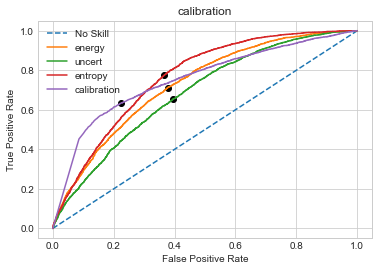

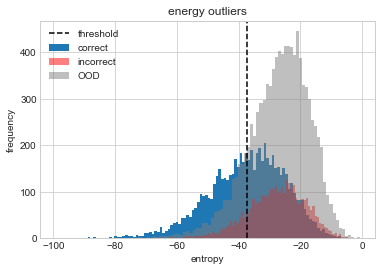

OOD accepted: 1480 : with threshold: -37.3288
ID accepted: 3575 :with acc: 0.8475524475524475
overall Accepted acc: 0.599406528189911
TPR_ID-OOD 0.3575
TPR_acc 0.46875
FPR_ID-OOD 0.148
FPR_acc 0.1541289592760181


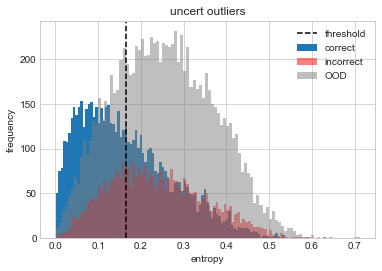

OOD accepted: 2543 : with threshold: 0.16586734
ID accepted: 4690 :with acc: 0.7742004264392324
overall Accepted acc: 0.5020047006774506
TPR_ID-OOD 0.469
TPR_acc 0.5617264851485149
FPR_ID-OOD 0.2543
FPR_acc 0.29949095022624433


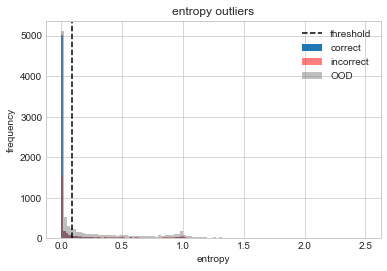

OOD accepted: 6098 : with threshold: 0.08850501
ID accepted: 7418 :with acc: 0.7314640064707468
overall Accepted acc: 0.4014501331754957
TPR_ID-OOD 0.7418
TPR_acc 0.8394183168316832
FPR_ID-OOD 0.6098
FPR_acc 0.5633484162895928


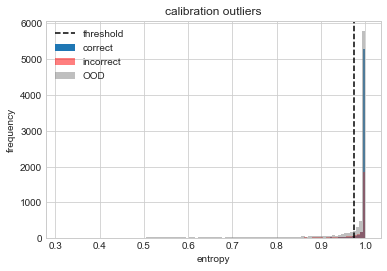

OOD accepted: 6723 : with threshold: 0.9752796
ID accepted: 7869 :with acc: 0.7158469945355191
overall Accepted acc: 0.3860334429824561
TPR_ID-OOD 0.7869
TPR_acc 0.8714418316831684
FPR_ID-OOD 0.6723
FPR_acc 0.6323529411764706


In [112]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

In [71]:
def combineThresholds(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        # if type(metrics ) is not list:
        #     metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")
        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID.loc[(ID[metric].tolist() <= energy_threshold)]
        _OOD = OOD.loc[(OOD[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold
        metric = 'energy'
        print("metric", metric)
        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((output_ID.loc[output_ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        _OOD_accepted = _OOD.loc[(_OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(_OOD_accepted))
        _ID_accepted = _ID.loc[(_ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(_ID_accepted))
        print("ID acc", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted))
        print("overall Acc (ID+OOD)", len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]
        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", energy_threshold, ",", len(_OOD), ",", len(_ID),",",
                                                       len(_ID.loc[_ID['correct']==True])/len(_ID),",",
                                                       correct_threshold, ",",len(_OOD_accepted),",",
                                                       len(_ID_accepted),",", ",",
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/len(_ID_accepted),',',
                                                       len(_ID_accepted.loc[_ID_accepted['correct'] == True])/(len(_ID_accepted)+len(_OOD_accepted)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
# combineThresholds(output_ID,output_OOD, metrics = ['energy'], excel=True)



def combineThresholds2(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"],excel=False):
        if type(metrics ) is not list:
            metrics = [metrics]
        # for i, metric in enumerate(metrics):
        metric  = 'energy'
        print("------", metric, "--------")

        # print( (output_ID.loc[output_ID['correct'] == True]))
        correct_threshold = np.array((ID.loc[ID['correct'] == True])[metric] ).mean()
        print("threshold", correct_threshold)
        OOD_accepted = OOD.loc[(OOD[metric].tolist() <= correct_threshold)]
        print("OOD accepted", len(OOD_accepted))
        ID_accepted = ID.loc[(ID[metric].tolist() <= correct_threshold)]
        print("ID accepted",len(ID_accepted))
        print("ID acc", len(ID_accepted.loc[ID_accepted['correct'] == True])/len(ID_accepted))
        print("overall Acc (ID+OOD)", len(ID_accepted.loc[ID_accepted['correct'] == True])/(len(ID_accepted)+len(OOD_accepted)))
        # _OOD = output_OOD.loc[(output_OOD[metric].tolist() <= energy_threshold)]


        metric  = 'energy'
        print("metric", metric)

        energy_threshold = np.array(ID[metric]).mean()
        print(energy_threshold)
        _ID = ID_accepted.loc[(ID_accepted[metric].tolist() <= energy_threshold)]
        _OOD = OOD_accepted.loc[(OOD_accepted[metric].tolist() <= energy_threshold)]
        print("OOD accepted",len(_OOD))
        print("ID accepted",len(_ID))
        print("ID acc", len(_ID.loc[_ID['correct']==True])/len(_ID))
        print("overall Acc (ID+OOD)", len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
        #### now T/F threshold

        if excel: #print out a single line with all the values for quick addition to excel                
            print(metric, ",", correct_threshold, ",", len(OOD_accepted), ",", len(ID_accepted),",",
                                                       len(ID_accepted.loc[ID_accepted['correct']==True])/len(ID_accepted),",",
                                                       energy_threshold, ",",len(_OOD),",",
                                                       len(_ID),",", ",",
                                                       len(_ID.loc[_ID['correct'] == True])/len(_ID),',',
                                                       len(_ID.loc[_ID['correct'] == True])/(len(_ID)+len(_OOD)))
# combineThresholds(output_ID,output_OOD, metrics = ['energy','uncert',"Energy_softmax","Energy_evidence","entropy"], excel=True)
combineThresholds2(output_ID,output_OOD, metrics = ['energy'], excel=True)

 # df = pd.DataFrame({"x":Results,"y":Labels,"uncert":Uncert,"energy":Energy,"Energy_softmax":Energy_softmax,"Energy_evidence":Energy_evidence,"Energy_alpha":Energy_alpha,"Energy_Mass":Energy_Mass,'entropy':Entropy,'calibration':calibration})

------ energy --------
threshold -49.350967
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
metric energy
-35.580128
OOD accepted 820
ID accepted 2952
ID acc 0.9258130081300813
overall Acc (ID+OOD) 0.7245493107104984
energy , -49.350967 , 820 , 2952 , 0.9258130081300813 , -35.580128 , 820 , 2952 , , 0.9258130081300813 , 0.7245493107104984


In [36]:
###find 95% TPR
def buildTPR(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
        if type(metrics ) is not list:
            metrics = [metrics]
        for i, metric in enumerate(metrics):
            _max =  np.array(ID[metric]).max()
            _min =  np.array(ID[metric]).min()
            linrange = np.linspace(_min, _max,100)
            print(len(linrange))
            total_correct = ID.loc[ID['correct'] == True]
            print(len(total_correct))
            # TP_qualifier = round(len(total_correct)*.95)
            TP_qualifier = round(len(ID)*.95)
            print("TP_qual",TP_qualifier)
            for point in linrange:
                # print(point)
                #get ID below this amount
                # TP = ID.loc[(ID[metric]<=point) & ID['correct'] == True]
                TP = ID.loc[(ID[metric]<=point) ]#& ID['correct'] == True]
                if len(TP) >=TP_qualifier:
                    FP = OOD.loc[(OOD[metric]<=point)]
                    print(point, "ID:", len(TP)," OOD:",len(FP))
            
            _ = plt.hist(ID[metric].tolist(), bins=100)  # arguments are passed to np.histogram
            _ = plt.hist(OOD[metric].tolist(), bins=100,color="red",alpha=0.5)  # arguments are passed to np.histogram
            # plt.title("Histogram with 'auto' bins")
            plt.title(metric + " outliers")
            plt.legend(legend)
            plt.xlabel("entropy")
            plt.ylabel("frequency")
            plt.show()
            # if threshold:
            #     if type(threshold) is list:
            #         if i >= len(threshold): #no threshold in the array so treat as None.
            #             continue
            #         _threshold = threshold[i]
            #     else:
            #         _threshold = threshold
            #     if _threshold == "mean":
            #         _threshold = np.array(ID[metric]).mean()
            #     print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
            #     print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
            #     print("Overall accuracy of accepted inputs:", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/(len(ID.loc[(ID[metric] <= _threshold)])+len(OOD.loc[(OOD[metric] <= _threshold)])))
            #     Correct = ID.loc[(ID['correct'] == True)]
            #     # print(len(Correct))
            #     Incorrect = ID.loc[(ID['correct'] == False)]
            #     print("overall acc on ID:",len(Correct)/len(ID))

100
6217
TP_qual 9500
-1.2737780062839246 ID: 9503  OOD: 9160
-1.2017745176951093 ID: 9572  OOD: 9291
-1.1297710291062941 ID: 9651  OOD: 9426
-1.0577675405174798 ID: 9697  OOD: 9516
-0.9857640519286655 ID: 9746  OOD: 9597
-0.9137605633398502 ID: 9796  OOD: 9649
-0.841757074751035 ID: 9830  OOD: 9687
-0.7697535861622207 ID: 9858  OOD: 9734
-0.6977500975734063 ID: 9881  OOD: 9769
-0.6257466089845911 ID: 9901  OOD: 9800
-0.5537431203957759 ID: 9918  OOD: 9818
-0.48173963180696155 ID: 9933  OOD: 9838
-0.4097361432181472 ID: 9938  OOD: 9852
-0.337732654629332 ID: 9945  OOD: 9869
-0.2657291660405168 ID: 9950  OOD: 9880
-0.19372567745170244 ID: 9957  OOD: 9893
-0.1217221888628881 ID: 9962  OOD: 9909
-0.04971870027407288 ID: 9966  OOD: 9920
0.022284788314742343 ID: 9971  OOD: 9931
0.09428827690355668 ID: 9976  OOD: 9937
0.166291765492371 ID: 9980  OOD: 9946
0.23829525408118624 ID: 9983  OOD: 9953
0.31029874267000146 ID: 9985  OOD: 9954
0.3823022312588158 ID: 9987  OOD: 9960
0.45430571984763013

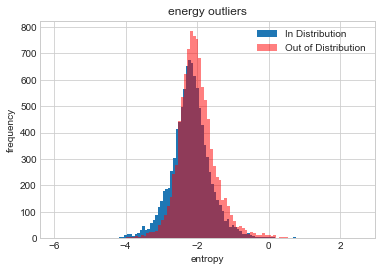

In [37]:
#crossEnergy
buildTPR(output_ID, output_OOD, ["energy"], "mean")

100
6408
TP_qual 9500
18.193120166508834 ID: 9663  OOD: 9363
22.363708650222918 ID: 9778  OOD: 9594
26.534297133937002 ID: 9868  OOD: 9744
30.704885617651144 ID: 9915  OOD: 9829
34.87547410136523 ID: 9945  OOD: 9885
39.04606258507931 ID: 9956  OOD: 9928
43.2166510687934 ID: 9966  OOD: 9955
47.38723955250748 ID: 9981  OOD: 9972
51.557828036221565 ID: 9986  OOD: 9981
55.728416519935706 ID: 9992  OOD: 9983
59.89900500364979 ID: 9995  OOD: 9988
64.06959348736387 ID: 9996  OOD: 9990
68.24018197107796 ID: 9998  OOD: 9994
72.41077045479204 ID: 9998  OOD: 9999
76.58135893850613 ID: 9998  OOD: 9999
80.75194742222027 ID: 9998  OOD: 10000
84.92253590593435 ID: 9999  OOD: 10000
89.09312438964844 ID: 10000  OOD: 10000


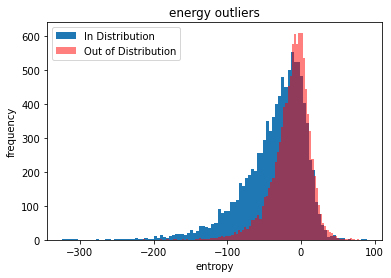

100
6408
TP_qual 9500
10.0 ID: 10000  OOD: 10000


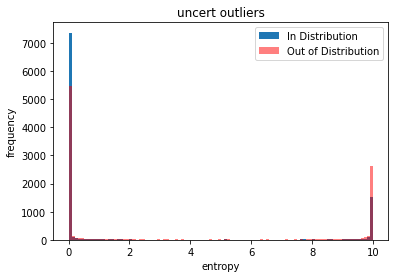

In [86]:
#EDL energy
buildTPR(output_ID, output_OOD, ["energy","uncert"], "mean")

In [88]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from matplotlib import pyplot
metrics = ['energy','entropy_of_expected']


def calc_aucpr(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    y_test = np.int32(output_df['correct'])
    
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = precision_recall_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, P={}, R={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        
        display = PrecisionRecallDisplay.from_predictions(y_test, output_df[metric], name="LinearSVC")
        _ = display.ax_.set_title("2-class Precision-Recall curve")
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy'],plot = True)
# print(threshold)

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
precision_recall_fscore_support(output_ID['x'], output_ID['y'], average='macro')
# roc_auc_score(output_ID['correct'], output_ID['energy'])

(0.6464000000000001, 0.6490218675861255, 0.6450334719396431, None)

-37.470623
energy  lr_auc 0.2722029825472649 Best Threshold=-32.56050109863281, G-Mean=0.66607395848115, TPR=0.7126696832579186, FPR=0.3774752475247525


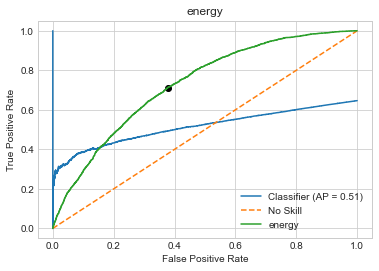

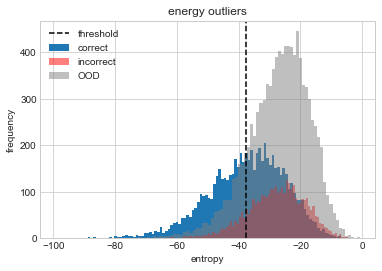

OOD accepted: 1447 : with threshold: -37.470623
ID accepted: 3537 :with acc: 0.8490245971162002
overall Accepted acc: 0.6025280898876404
TPR_ID-OOD 0.3537
TPR_acc 0.4645730198019802
FPR_ID-OOD 0.1447
FPR_acc 0.1510180995475113


In [104]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
y_test = output_ID['correct']
X_test = output_ID['energy']
precision_, recall_, proba = precision_recall_curve(y_test, X_test)

PrecisionRecallDisplay.from_predictions(output_ID['correct'], output_ID['energy'])

# PrecisionRecallDisplay(X_test, y_test)
# disp.ax_.set_title('Precision-Recall curve')

optimal_proba_cutoff = sorted(list(zip(np.abs(precision_ - recall_), proba)), key=lambda i: i[0], reverse=False)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in X_test]
print(optimal_proba_cutoff)
# print(roc_predictions)
buildCompareDistribPlot(output_ID, output_OOD, ["energy"], optimal_proba_cutoff)

Best Threshold=-76.6483383178711, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=0.004616542719304562, G-Mean=0.8034387247706902, P=1.0, R=0.3544862155388471
Best Threshold=3.495582809081781e-19, G-Mean=0.8007025231631392, P=1.0, R=0.35887546940018267
Best Threshold=0.3779428005218506, G-Mean=0.5945340142824697, P=1.0, R=0.6465293058611722


[]

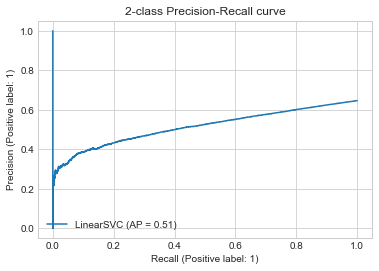

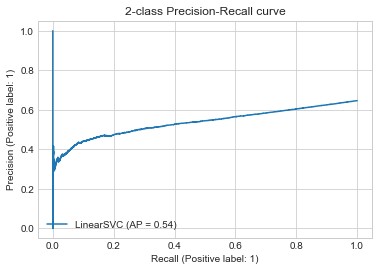

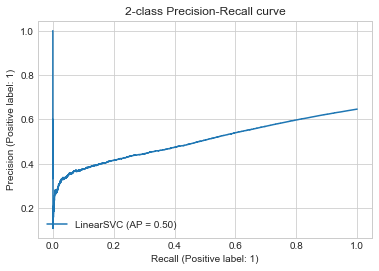

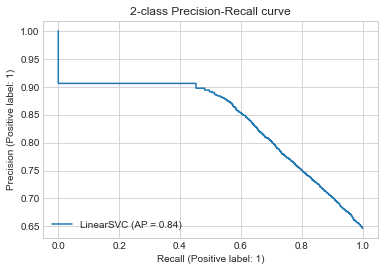

In [89]:
calc_aucpr(output_ID,metrics=["energy",'uncert','entropy','calibration'],plot=False)

max,min 1.0 0.36905995
0.3690599501132965 6464 3536
0.3754330819303339 6464 3535
0.38180621374737134 6463 3532
0.38817934556440875 6463 3531
0.39455247738144616 6463 3531
0.4009256091984835 6463 3528
0.407298741015521 6463 3526
0.41367187283255835 6463 3526
0.42004500464959577 6463 3524
0.4264181364666332 6463 3521
0.4327912682836706 6462 3517
0.439164400100708 6460 3517
0.4455375319177454 6460 3514
0.45191066373478284 6458 3513
0.45828379555182025 6458 3513
0.46465692736885766 6456 3509
0.471030059185895 6456 3506
0.4774031910029325 6456 3499
0.48377632281996985 6454 3495
0.49014945463700726 6452 3491
0.4965225864540447 6451 3488
0.502895718271082 6447 3481
0.5092688500881195 6438 3476
0.515641981905157 6435 3464
0.5220151137221943 6429 3452
0.5283882455392317 6425 3441
0.5347613773562692 6419 3430
0.5411345091733065 6415 3421
0.547507640990344 6411 3414
0.5538807728073813 6406 3406
0.5602539046244188 6401 3387
0.5666270364414562 6392 3379
0.5730001682584935 6385 3366
0.57937330007553

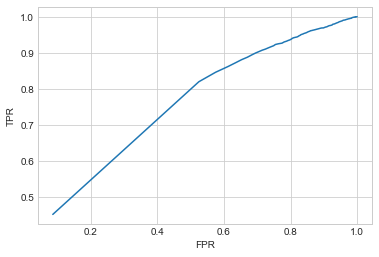

In [72]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot

def self_calc_AUC(output_df, metrics=['energy'], plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        #order the dataframe from lowest to highest
        df = output_df.sort_values(by=[metric,'correct'])
        t_max = df[metric].max()
        t_min = df[metric].min()
        print("max,min", t_max,t_min)
        #create a linspace
        linspace = np.linspace(t_min, t_max,num=100)
        Total_P = len(df.loc[df['correct']==True])
        Total_F = len(df.loc[df['correct']==False])
        TPR=[]
        FPR=[]
        for thresh in linspace:
            _outputs = df.loc[df[metric]>= thresh]
            correct = _outputs.loc[_outputs['correct']==True]
            incorrect = _outputs.loc[_outputs['correct']==False]
            print(thresh, len(correct), len(incorrect))
            _TPR = len(correct)/ Total_P
            _FPR = len(incorrect)/ Total_F
            TPR.append(_TPR)
            FPR.append(_FPR)
        # print(FPR)
        # print(TPR)
        pyplot.plot(FPR, TPR)
        pyplot.xlabel("FPR")
        pyplot.ylabel("TPR")
        pyplot.show()#     
# threshold = self_calc_AUC(output_ID, metrics=['energy'],plot = True)   
threshold = self_calc_AUC(output_ID, metrics=['calibration'],plot = True)   

energy  lr_auc 0.23328679452194093 Best Threshold=-48.40744400024414, G-Mean=0.7009286192837358, TPR=0.7452460850111857, FPR=0.3407534246575342


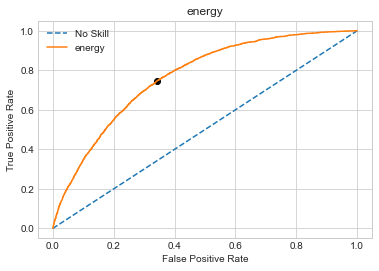

calibration  lr_auc 0.6673192808846022 Best Threshold=1.0, G-Mean=0.638403421479321, TPR=0.8429327521793275, FPR=0.5164988814317674


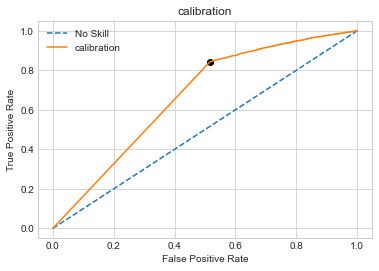

In [61]:
threshold = calc_AUC(output_ID, metrics=["energy"],plot = True)
threshold = calc_AUC(output_ID, metrics=["calibration"],plot = True)

In [41]:
# calculate scores
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve

from matplotlib import pyplot
# metrics = ['energy','entropy_of_expected']


def calc_AUC(output_df,metrics=['energy'],plot=False):
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    
    y_test = np.int32(output_df['correct'])
    plots = []
    for metric in metrics:    
        lr_auc = roc_auc_score(y_test, output_df[metric])
        
        if metric in lessThanMetrics:
            pos_label = 0
        else:
            pos_label = 1
        fpr, tpr, thresholds = roc_curve(y_test, output_df[metric],pos_label=pos_label)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print(metric," lr_auc",lr_auc, 'Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
        _thresholds.append(threshold)
        # plot the roc curve for the model
        plots.append({"fpr":fpr,"tpr":tpr,"label":metric, "ix":ix})
    if plot:
        pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
        for plot in plots:
            ix = plot['ix']
            pyplot.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

            pyplot.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
        # axis labels
        pyplot.xlabel('False Positive Rate')
        pyplot.ylabel('True Positive Rate')
        pyplot.title(metric)
        pyplot.legend()
        # show the plot
        pyplot.show()

#         accepted = output_df.loc[output_df[metric] <= threshold]
#         y_test_accept = np.int32(accepted['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted[metric])
#         print(len(thresholds))
#         print("lr_auc_accepted",lr_auc)

#         threshold2 = np.array(output_df.loc[output_df['correct']==True][metric]).mean()
#         accepted2 = output_df.loc[output_df[metric] <= threshold2]
#         y_test_accept = np.int32(accepted2['correct'])
#         lr_auc = roc_auc_score(y_test_accept, accepted2[metric])
#         print("lr_auc_accepted2",lr_auc)



#         print(len(accepted), len(accepted.loc[(accepted['correct'] == True)]))
#         _ = pyplot.hist(output_df[metric].tolist(), bins=100,alpha=0.5)  # arguments are passed to np.histogram
#         _ = pyplot.hist(output_df.loc[(output_df['correct'] == True)][metric].tolist(), bins=100)  # arguments are passed to np.histogram
#         plt.axvline(x=threshold, color='k', linestyle='--',label="threshold")
#         pyplot.show()
            
    return _thresholds

# threshold = calc_gmeans(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)


# print(threshold)

energy  lr_auc 0.23581525312294546 Best Threshold=-65.02085876464844, G-Mean=0.6930189181980165, TPR=0.7151234567901235, FPR=0.32840236686390534
entropy  lr_auc 0.21818394331214847 Best Threshold=7.617240171953199e-10, G-Mean=0.7112415642998093, TPR=0.7209876543209877, FPR=0.29837278106508874
uncert  lr_auc 0.2504219857184601 Best Threshold=0.01307495404034853, G-Mean=0.6874553625126794, TPR=0.6984567901234567, FPR=0.32337278106508877
confidence_alea_uncert  lr_auc 0.6952099998173716 Best Threshold=1.0, G-Mean=0.679469876950052, TPR=0.7714497041420119, FPR=0.4015432098765432
entropy_of_expected  lr_auc 0.7661175031046826 Best Threshold=-3.731665636471849e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
expected_entropy  lr_auc 0.7663178921031485 Best Threshold=-3.909963365774104e-09, G-Mean=0.7051306980012914, TPR=0.7013313609467455, FPR=0.2910493827160494
calibration  lr_auc 0.6932918310322156 Best Threshold=1.0, G-Mean=0.6743145587834388, TPR=0.797633136

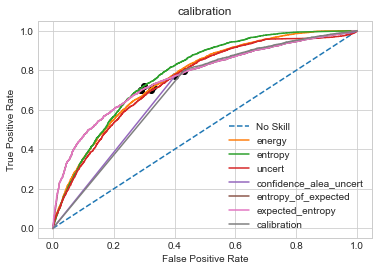

In [42]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)

energy  lr_auc 0.30746509020901197 Best Threshold=-12.230971336364746, G-Mean=0.6447222206555288, TPR=0.6918058455114823, FPR=0.39915693904020755
entropy  lr_auc 0.23931991909214234 Best Threshold=0.7835158109664917, G-Mean=0.6983915306471645, TPR=0.759133611691023, FPR=0.35749027237354086
uncert  lr_auc 0.35281864661435275 Best Threshold=0.3646439015865326, G-Mean=0.6121356188521229, TPR=0.6072546972860126, FPR=0.3829442282749676
confidence_alea_uncert  lr_auc 0.7616135598848119 Best Threshold=0.832136869430542, G-Mean=0.6976568205033336, TPR=0.6507782101167315, FPR=0.2520876826722338
entropy_of_expected  lr_auc 0.7578205598157641 Best Threshold=-0.5445331625295522, G-Mean=0.6981025938832756, TPR=0.6371595330739299, FPR=0.23512526096033404
expected_entropy  lr_auc 0.7583946471653817 Best Threshold=-0.540065626234581, G-Mean=0.6982834773852532, TPR=0.6355382619974059, FPR=0.23277661795407098
calibration  lr_auc 0.7630961428979526 Best Threshold=0.8225886821746826, G-Mean=0.697887108646

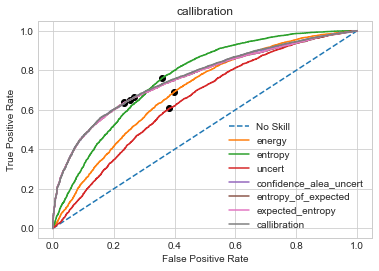

In [17]:
# threshold = calc_AUC(output_ID, metrics=['energy','uncert','expected_entropy','calibration'],plot = True)
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#MAEB

lr_auc 0.29612755195940693
Best Threshold=-7.480616569519043, G-Mean=0.6498070813025146, TPR=0.7059282371294852, FPR=0.4018524536886578
lr_auc 0.24005162351440434
Best Threshold=0.9972052574157715, G-Mean=0.6950418578983907, TPR=0.7927717108684348, FPR=0.39064023399415015
lr_auc 0.37206364432672856
Best Threshold=0.44796812534332275, G-Mean=0.5952901008407016, TPR=0.6315652626105044, FPR=0.43890152746181343
lr_auc 0.7651199808148321
Best Threshold=0.7181436419487, G-Mean=0.7008415143051968, TPR=0.6670458238544036, FPR=0.26365054602184085
lr_auc 0.7568078446244773
Best Threshold=-0.8272647119808325, G-Mean=0.6919269077521468, TPR=0.6494962625934352, FPR=0.2628705148205928
lr_auc 0.7574571523647426
Best Threshold=-0.8330044417222909, G-Mean=0.6924701182740562, TPR=0.6542086447838804, FPR=0.2670306812272491
lr_auc 0.7660429881608655
Best Threshold=0.7298916578292847, G-Mean=0.7018544841976537, TPR=0.6711082222944427, FPR=0.265990639625585


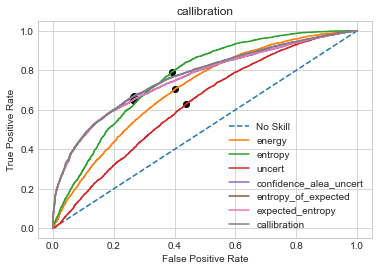

In [82]:
threshold = calc_AUC(output_ID, metrics=["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"],plot = True)
#EDL

3.2326987
OOD size 10000
lr_auc 0.7541746142769092
Best Threshold=3.2167084217071533, G-Mean=0.6892592415221137, TPR=0.7929797591596208, FPR=0.4008947939262473
0.90874654
OOD size 10000
lr_auc 0.7183908266851695
Best Threshold=0.07692579925060272, G-Mean=0.6652858844957924, TPR=0.7575091575091575, FPR=0.41570962710903164


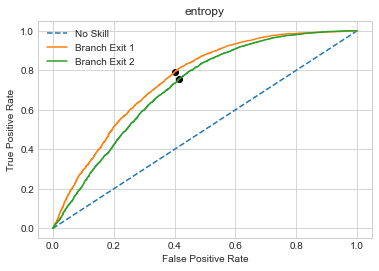

In [75]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
# metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
# metrics =['energy','uncert','expected_entropy','calibration']

metrics = ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
def calc_auc_OOD(ID,OOD,metrics=['energy'],OOD_rate=[.1,.2,.5,1], plot=False):
    points = []
    # OOD_rate = [0,.1,.2,.5,1]
    # _output_ID["outlier"]=0
    # _output_OOD["outlier"]=1
    lessThanMetrics = ["energy","uncert","entropy"]
    _thresholds = []
    plots = []
    for i, (output_ID, output_OOD) in enumerate(zip(ID, OOD)): 
        if i >= len(ID)-1:
            continue
        for j in OOD_rate:
            #calculate 
            # threshold = lr_auc = calc_AUC(output_ID['correct'], output_ID[metric])
            for metric in metrics:    

                fpr, tpr, thresholds = roc_curve(output_ID['correct'], output_ID[metric],pos_label=1)
                gmeans = sqrt(tpr * (1-fpr))
                # print(gmeans)
                # locate the index of the largest g-mean
                ix = argmax(gmeans)
                threshold = thresholds[ix]
                print(threshold)
                _OOD = output_OOD.iloc[0:int(min((len(output_ID) * j),len(output_OOD)))]
                print("OOD size",len(_OOD))
                _df = pd.concat([output_ID,_OOD], ignore_index=True)
                Accepted = _df.loc[_df[metric] <= threshold]
                y_true = np.int32(Accepted['outlier'])

                lr_auc = roc_auc_score(y_true, Accepted[metric])
                print("lr_auc",lr_auc)
                if metric in lessThanMetrics:
                    pos_label = 1
                else:
                    pos_label = 0
                fpr, tpr, thresholds = roc_curve(y_true, Accepted[metric],pos_label=pos_label)
                gmeans = sqrt(tpr * (1-fpr))
                # print(gmeans)
                # locate the index of the largest g-mean
                ix = argmax(gmeans)
                threshold = thresholds[ix]
                print('Best Threshold={}, G-Mean={}, TPR={}, FPR={}'.format(threshold, gmeans[ix],tpr[ix],fpr[ix]))
                _thresholds.append(threshold)
                # plot the roc curve for the model
                plots.append({"fpr":fpr,"tpr":tpr,"label":"Branch Exit {}".format(i+1), "ix":ix})
            # if plot:
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    for plot in plots:
        ix = plot['ix']
        plt.plot(plot["fpr"], plot["tpr"],  label=plot['label'])

        plt.scatter(plot["fpr"][ix], plot["tpr"][ix], marker='o', color='black')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(metric)
    plt.legend()
    # show the plot
    plt.show()

# calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       

calc_auc_OOD(output_ID,output_OOD,metrics=['entropy'],OOD_rate=[1])       


10000
lr_auc 0.17632298999999999
Best Threshold=-5.625901222229004, G-Mean=0.7577538320589345, TPR=0.7897, FPR=0.2729
lr_auc 0.163048365
Best Threshold=1.7985261678695679, G-Mean=0.7553904420893873, TPR=0.7592, FPR=0.2484
lr_auc 0.26289053
Best Threshold=0.45931094884872437, G-Mean=0.6940969240675253, TPR=0.7773, FPR=0.3802
lr_auc 0.83095955
Best Threshold=0.49477264285087585, G-Mean=0.7527356375248883, TPR=0.7481, FPR=0.2426
lr_auc 0.8377772299999999
Best Threshold=-1.3245874584253854, G-Mean=0.7618700217228658, TPR=0.7367, FPR=0.2121
lr_auc 0.83854707
Best Threshold=-1.3036969119965915, G-Mean=0.7614107432916875, TPR=0.7346, FPR=0.2108
lr_auc 0.8264950799999999
Best Threshold=0.5462754368782043, G-Mean=0.7462074711499478, TPR=0.7087, FPR=0.2143


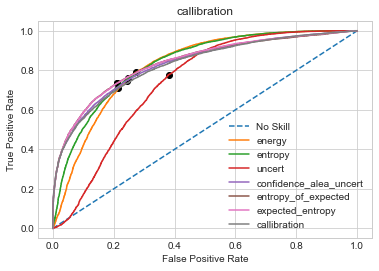

10000
lr_auc 0.3541886000000001
Best Threshold=-6.632209777832031, G-Mean=0.6040072847242821, TPR=0.6247, FPR=0.416
lr_auc 0.33489378000000003
Best Threshold=1.3389952182769775, G-Mean=0.6181435512888571, TPR=0.6535, FPR=0.4153
lr_auc 0.41053229999999996
Best Threshold=0.45440253615379333, G-Mean=0.5676407754909789, TPR=0.5759, FPR=0.4405
lr_auc 0.6552974600000001
Best Threshold=0.6583983302116394, G-Mean=0.6085316014801532, TPR=0.5677, FPR=0.3477
lr_auc 0.6647074949999999
Best Threshold=-1.0051595671170843, G-Mean=0.6170466676030266, TPR=0.5873, FPR=0.3517
lr_auc 0.6649351350000001
Best Threshold=-0.9957128697464878, G-Mean=0.6170181682900431, TPR=0.5858, FPR=0.3501
lr_auc 0.652951265
Best Threshold=0.7174296975135803, G-Mean=0.6068091627521787, TPR=0.5292, FPR=0.3042


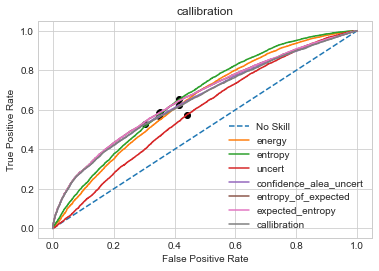

In [81]:
calc_auc_OOD(output_ID,output_OOD_svhn,metrics=metrics,OOD_rate=[1])       


calc_auc_OOD(output_ID,output_OOD,metrics=metrics,OOD_rate=[1])       

In [46]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy","calibration"]
metrics =["energy","entropy","calibration"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=0
_output_OOD["outlier"]=1
lessThanMetrics = ["energy","uncert","entropy"]
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # print(metric, ":", average_precision_score(y_true, _df[metric]))
        
        Correct = _df.loc[(_df['correct'] == True)]
        Incorrect = _df.loc[(_df['correct'] == False)]
        fpr, tpr, thresholds = roc_curve(np.int32(_output_ID['correct']), _output_ID[metric],pos_label=1)
        gmeans = sqrt(tpr * (1-fpr))
        ix = argmax(gmeans)
        _threshold = thresholds[ix]
        # _threshold = np.array(Correct[metric]).mean()
        if metric in lessThanMetrics:
            accepted = _df.loc[(_df[metric] <= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)]
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] <= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] > _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] <= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] > _threshold)] #TN
            # print(metric, ":", len(Correct)/len(_df), "accepted_acc", len(accepted_correct)/len(accepted))
        else:
            accepted = _df.loc[(_df[metric] >= _threshold)] #TP
            accepted_OOD = accepted.loc[(accepted['outlier'] == 1)] #TP
            accepted_ID = accepted.loc[(accepted['outlier'] == 0)] 
            accepted_correct = Correct.loc[(Correct[metric] >= _threshold)] #TP
            rejected_correct = Correct.loc[(Correct[metric] < _threshold)]  #FN

            accepted_incorrect = Incorrect.loc[(Incorrect[metric] >= _threshold)] #FP
            rejected_incorrect = Incorrect.loc[(Incorrect[metric] < _threshold)] #TN
        try:
            ODD_accept = len(accepted_OOD)/len(_OOD)
        except:
            ODD_accept ="NAN"
        np.seterr(invalid='ignore')
        AUC_PR_OOD = average_precision_score(np.int32(accepted['outlier']), accepted[metric])
        AUC_ROC = roc_auc_score(np.int32(accepted['correct']), accepted[metric])
        AUC_PR = average_precision_score(np.int32(accepted['correct']), accepted[metric])
        FPR = len(accepted_incorrect) / (len(accepted_incorrect) + len(rejected_incorrect))
        print(metric,":",len(accepted_ID)/len(_output_ID),":",ODD_accept, ":", len(accepted_correct)/len(accepted), ":FPR:",FPR,":AUC_PR(T/F):",AUC_PR,":AUC_ROC:",AUC_ROC)


0
10000
energy : 0.5996 : NAN : 0.7198132088058706 :FPR: 0.4384133611691023 :AUC_PR(T/F): 0.6245638987195575 :AUC_ROC: 0.3303461097135796
entropy : 0.5763 : NAN : 0.7666146104459483 :FPR: 0.3509916492693111 :AUC_PR(T/F): 0.6477462359394405 :AUC_ROC: 0.25846595795167115
calibration : 0.5131 : NAN : 0.7998440849736893 :FPR: 0.2680062630480167 :AUC_PR(T/F): 0.9133633355608572 :AUC_ROC: 0.7249858119278505
1000
11000
energy : 0.5996 : 0.412 : 0.6735330836454432 :FPR: 0.4329470198675497 :AUC_PR(T/F): 0.5706115701137225 :AUC_ROC: 0.32503273869119664
entropy : 0.5763 : 0.344 : 0.7234321270672999 :FPR: 0.34954470198675497 :AUC_PR(T/F): 0.5999034689406928 :AUC_ROC: 0.26439191519916505
calibration : 0.5131 : 0.288 : 0.7573353017161838 :FPR: 0.2721440397350993 :AUC_PR(T/F): 0.8915049540682882 :AUC_ROC: 0.7213421571461396
2000
12000
energy : 0.5996 : 0.409 : 0.6334018197828001 :FPR: 0.4283264746227709 :AUC_PR(T/F): 0.5270595868474839 :AUC_ROC: 0.3237112396126354
entropy : 0.5763 : 0.342 : 0.6852799

0
10000
Best Threshold=-1.9426160284718987, G-Mean=0.82936722867497, Recall=1.0, Precision=0.37573757375737576


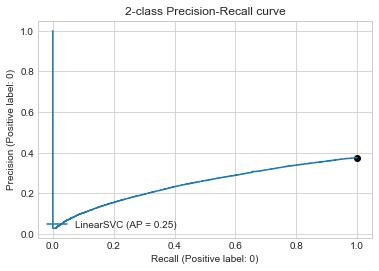

1000
11000
Best Threshold=-1.9430203248942899, G-Mean=0.82936722867497, Recall=1.0, Precision=0.4324545454545455


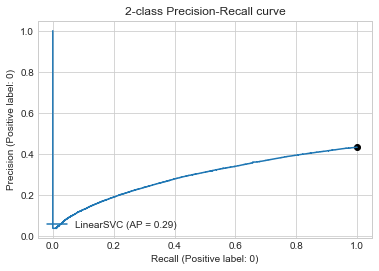

2000
12000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.47975


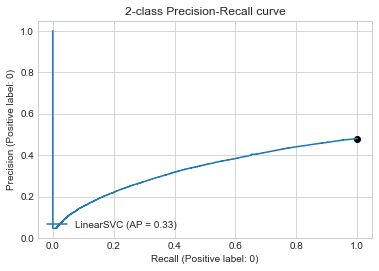

5000
15000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.5838


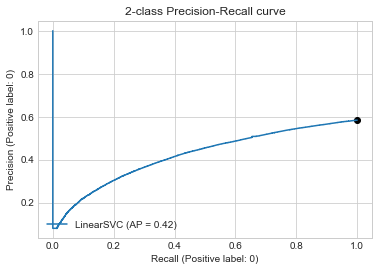

10000
20000
Best Threshold=-1.9433633677794055, G-Mean=0.82936722867497, Recall=1.0, Precision=0.68785


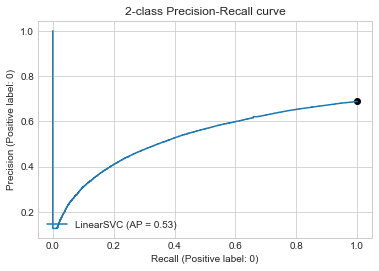

In [256]:
from sklearn.metrics import average_precision_score

metrics =["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"]
metrics =["expected_entropy"]
points = []

OOD_rate = [0,.1,.2,.5,1]

_output_ID = output_ID
_output_OOD = output_OOD

_output_ID["outlier"]=1
_output_OOD["outlier"]=0
for i in OOD_rate:
    print(int(min((len(_output_ID) * i),len(_output_ID))))
    _OOD = _output_OOD.iloc[0:int(min((len(_output_ID) * i),len(_output_ID)))]
    _df = pd.concat([_output_ID,_OOD], ignore_index=True)
    y_true = np.int32(_df['outlier'])
    
    print(len(_df))
    for metric in metrics:
        points.append([])
        # calc_aucpr(_df,plot=True)
        precision, recall, thresholds = precision_recall_curve(np.int32(_df['correct']), _df[metric],pos_label =0)
        gmeans = sqrt(tpr * (1-fpr))
        # print(gmeans)
        # locate the index of the largest g-mean
        ix = argmax(gmeans)
        threshold = thresholds[ix]
        print('Best Threshold={}, G-Mean={}, Recall={}, Precision={}'.format(threshold, gmeans[ix],recall[ix],precision[ix]))
        
        display = PrecisionRecallDisplay.from_predictions( np.int32(_df['correct']), _df[metric], name="LinearSVC",pos_label =0 )
        _ = display.ax_.set_title("2-class Precision-Recall curve") 
        pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
        plt.show()
        # Correct = _df.loc[(_df['correct'] == True)]
        # Incorrect = _df.loc[(_df['correct'] == False)]
        # print(metric, ":", len(Correct)/len(_df))

        


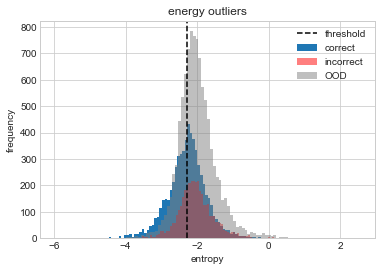

OOD accepted: 2780 : with threshold: -2.2853544
ID accepted: 4042 :with acc: 0.735526966848095
overall Accepted acc: 0.43579595426561124
TPR_ID-OOD 0.4042
TPR_acc 0.47820492198809716
FPR_ID-OOD 0.278
FPR_acc 0.2825799629923341


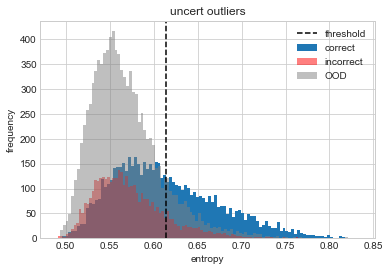

OOD accepted: 8740 : with threshold: 0.61375415
ID accepted: 6719 :with acc: 0.5194225331150469
overall Accepted acc: 0.22575845785626497
TPR_ID-OOD 0.6719
TPR_acc 0.5613640019301914
FPR_ID-OOD 0.874
FPR_acc 0.8535553793285752


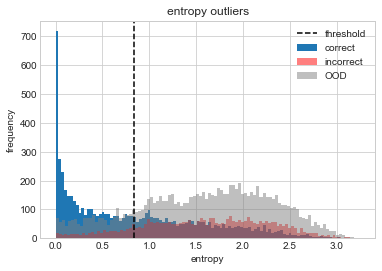

OOD accepted: 1767 : with threshold: 0.83682126
ID accepted: 4076 :with acc: 0.8626104023552502
overall Accepted acc: 0.6017456785897656
TPR_ID-OOD 0.4076
TPR_acc 0.5655460833199292
FPR_ID-OOD 0.1767
FPR_acc 0.14803066349458102


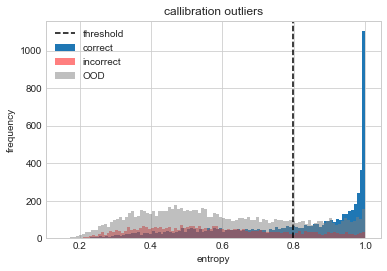

OOD accepted: 2215 : with threshold: 0.79617167
ID accepted: 4416 :with acc: 0.845108695652174
overall Accepted acc: 0.5628110390589655
TPR_ID-OOD 0.4416
TPR_acc 0.6002895287115972
FPR_ID-OOD 0.2215
FPR_acc 0.18080888183980967


In [35]:
buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy','calibration'], "mean")

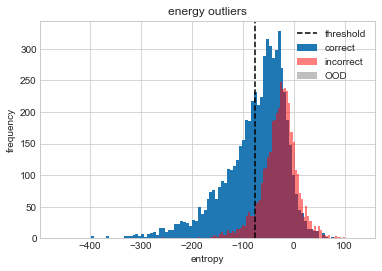

OOD accepted: 0 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8790149892933619
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR for OOD is div by zero, was OOD included?
FPR_acc 0.08580106302201974


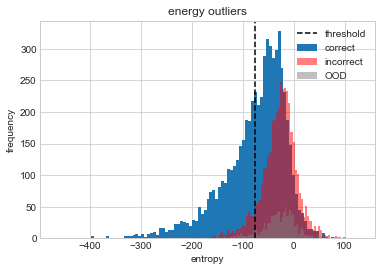

OOD accepted: 94 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8504834254143646
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.094
FPR_acc 0.08580106302201974


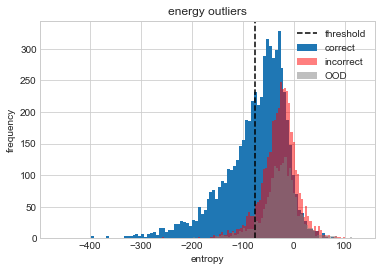

OOD accepted: 173 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.8278991596638655
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0865
FPR_acc 0.08580106302201974


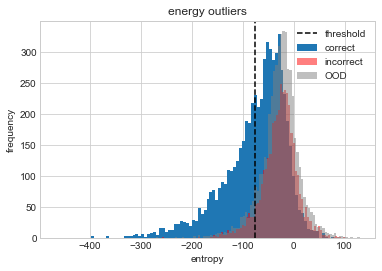

OOD accepted: 455 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.7562173779551735
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.091
FPR_acc 0.08580106302201974


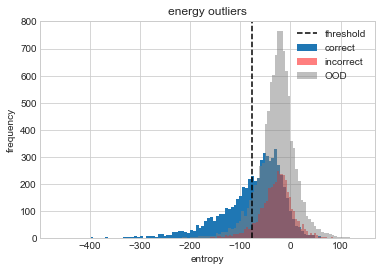

OOD accepted: 904 : with threshold: -76.06987
ID accepted: 2802 :with acc: 0.8790149892933619
overall Accepted acc: 0.6645979492714517
TPR_ID-OOD 0.2802
TPR_acc 0.4071747396263845
FPR_ID-OOD 0.0904
FPR_acc 0.08580106302201974


In [97]:
# buildCompareDistribPlot(output_ID, output_OOD, ["energy",'uncert','entropy'], "mean")

# buildCompareDistribPlot(output_ID, output_OOD, ["energy","entropy","uncert","confidence_alea_uncert","entropy_of_expected","expected_entropy"], threshold = "gmean")
# buildCompareDistribPlot(output_ID, output_OOD, ["energy","energy"], threshold = [-25.654110,"mean",-1.9786984131020736e-08])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:0], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:1000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:2000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:5000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])
buildCompareDistribPlot(output_ID, output_OOD.iloc[0:10000], ["energy"],"mean")# threshold = [-25.654110,"mean",-320.76513671875])



-13.265087624612557


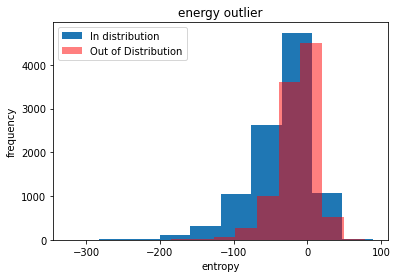

OOD accepted with avg ID entropy threshold of  -13.265087624612557 :  4201 out of  9984
ID accepted with avg ID entropy threshold of  -13.265087624612557 :  6518 out of  9984 with acc of  0.7821417612764652
overall acc on ID: 0.6409254807692307


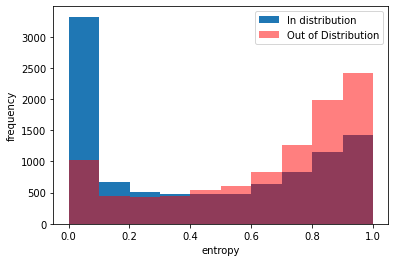

OOD accepted with avg ID entropy threshold of  0.6440355 :  3811 out of  9984
ID accepted with avg ID entropy threshold of  0.6440355 :  6209 out of  9984 with acc of  0.7935255274601385
overall acc on ID: 0.6409254807692307


In [286]:

energy_threshold = np.array(output_OOD['energy']).mean()
print(energy_threshold)
buildOutlierPlot_energy_2(output_ID, output_OOD, energy_threshold)

edl_threshold = output_OOD['uncert'].mean()
buildOutlierPlot(output_ID, output_OOD, edl_threshold)

In [ ]:
def buildOutlierPlot_multi(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]

                percents.append(percent/2)
                accuracy.append(len(Correct) / total_inputs)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("outliers")
        plt.legend(metrics)
        plt.xlabel("Outlier percentage")
        plt.ylabel("Accuracy")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

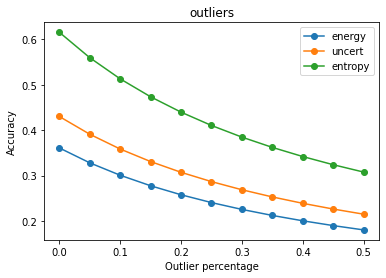

In [20]:
multiplot = buildOutlierPlot_multi(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")

In [36]:
def buildOutlierPlot_AUC(ID,OOD,metrics=["energy"], threshold=None, legend=["In Distribution","Out of Distribution"]):
    # for k in ['confidence_alea_uncert.','entropy_of_expected','expected_entropy','mutual_information','EPKL','differential_entropy']:
        # _ = plt.hist(ID[k].tolist(), bins=10)  # arguments are passed to np.histogram
        # _ = plt.hist(OOD[k].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
        plots = []
        points=[]
        if type(metrics ) is not list:
            metrics = [metrics]
            
        for i, metric in enumerate(metrics):
            accuracy = []
            percents = []
            if threshold:
                if type(threshold) is list:
                    if i >= len(threshold): #no threshold in the array so treat as None.
                        continue
                    _threshold = threshold[i]
                else:
                    _threshold = threshold
                if _threshold == "mean":
                    _threshold = np.array(ID[metric]).mean()
                    
            for i in range(11):
                # _OOD = OOD[]
                percent = i / 10
                # print(percent)
                OOD_size = int(len(OOD) * percent)
                _OOD = OOD.head(OOD_size)

                # _ = plt.hist(ID["energy"].tolist(), bins=10)  # arguments are passed to np.histogram
                # _ = plt.hist(_OOD["energy"].tolist(), bins=10,color="red",alpha=0.5)  # arguments are passed to np.histogram
                # plt.title("Histogram with 'auto' bins")
                Correct = (ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)])
                total_inputs = len(ID) + len(_OOD)
                
                # print(len(Correct), len(Correct) / total_inputs)
                
                # Incorrect = ID.loc[(ID['correct'] == False)]
                
                # Correct = ID.loc[(ID['correct'] == True)]
                Incorrect = ID.loc[(ID['correct'] == False)]
                #x =  false positive / sum(false positive + True Negative)
                # that thresholded are negative, so ID thresh is FN, OOD thresh is TN
                TP =  ID.loc[ID[metric]<=_threshold] #ID that are accepted 
                TN = _OOD.loc[_OOD[metric]>_threshold] #OOD that are not accepted 
                FN =  _OOD.loc[_OOD[metric]<=_threshold] #ID that are accepted 
                FP =  ID.loc[ID[metric]>_threshold] #ID that are accepted 
                
                _TP = len(TP)
                _TN = len(TN)
                _FN = len(FN)
                _FP = len(FP)
                
                # print("TP", len(TP), "TN",len(TN),"FN",len(FN),"FP",len(FP))
                x = _FP/ (_FP + _TN)
                
                y = _TP/(_TP+_FN)
                
                print(x,y)
                percents.append(x)
                accuracy.append(y)
            plots.append(accuracy)
            points.append(percents)



        # title ="{0:.2f}".format(percent)
        # print(plots)
        for i, plot in enumerate(plots):
            plt.plot(points[i],plot,marker = 'o')
        plt.title("AUC OOD")
        plt.legend(legend)
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

#         print("OOD accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(OOD.loc[(OOD[metric].tolist() <= _threshold)]), "out of ", len(OOD))
#         print("ID accepted with avg ID ",metric," threshold of ",_threshold, ": ", len(ID.loc[(ID[metric] <= _threshold)]), "out of ", len(ID), "with acc of ", len(ID.loc[(ID[metric] <= _threshold) & ID['correct'] == True])/len(ID.loc[(ID[metric] <= _threshold)]))
#         Correct = ID.loc[(ID['correct'] == True)]
#         Incorrect = ID.loc[(ID['correct'] == False)]
#         print("overall acc on ID:",len(Correct)/len(ID))

1.0 1.0
0.8737792246226694 0.9656723484848485
0.7777924130663857 0.9295806745670009
0.699893327011971 0.8980625275209159
0.6356297093649085 0.8702794964796245
0.5818307222386442 0.8450383260824529
0.5384825825278132 0.8144968051118211
0.4997461069735951 0.7911171450737006
0.4664296998420221 0.7680286198456034
0.43747221810638615 0.7455675379272528
0.4119575833682154 0.7239971600993965
1.0 1.0
0.8673469387755102 0.9523721275018532
0.7658868163136263 0.9089140431552883
0.6846121237812632 0.8707217892239919
0.618379068283344 0.8366981439270595
0.5639622861133745 0.8048551292090838
0.5199055692670888 0.7722013523666417
0.4803212055120452 0.74640522875817
0.4472858197932053 0.7198487183078862
0.41832153341391815 0.6956816028157574
0.3937423811458757 0.6706250815607464
1.0 1.0
0.849329205366357 0.9149106161989414
0.7421100090171325 0.8427007634992181
0.6495659037095501 0.7821892076502732
0.5857651245551602 0.7286827871460388
0.5323415265200517 0.6821295606850335
0.4852594339622642 0.64161647

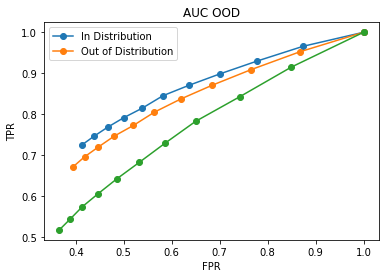

In [37]:
multiplot = buildOutlierPlot_AUC(output_ID, output_OOD,metrics=["energy",'uncert','entropy'], threshold="mean")